In [1]:
library("rethinking", lib.loc="/home/rer/R/x86_64-pc-linux-gnu-library/3.6/")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


Code 2.1

In [2]:
ways <- c(0,3,8,9,0)
ways/sum(ways)

[1] 0.00 0.15 0.40 0.45 0.00

Code 2.2

In [3]:
dbinom( 6 , size=9 , prob=0.5 )

[1] 0.1640625

Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In [4]:
num_points <- 100
# define grid
p_grid <- seq( from=0 , to=1 , length.out=num_points )

# define prior
#prior <- rep( 1 , num_points )
prior <- ifelse( p_grid < 0.5 , 0 , 2 )
#prior <- exp( -5*abs( p_grid - 0.5 ) )

# compute likelihood at each value in grid
likelihood <- dbinom( 6 , size=9 , prob=p_grid )

# compute product of likelihood and prior
unstd.posterior <- likelihood * prior

# standardize the posterior, so it sums to 1
posterior <- unstd.posterior / sum(unstd.posterior)

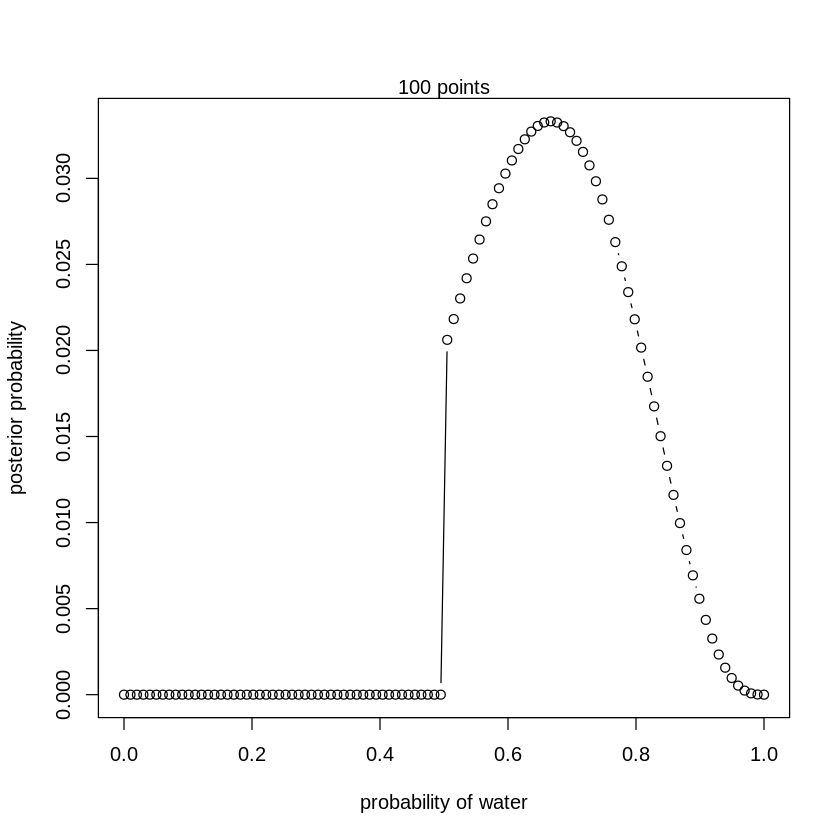

In [5]:
plot( p_grid , posterior , type="b" ,
xlab="probability of water" , ylab="posterior probability" )
#mtext("20 points")
mtext(sprintf("%d points", num_points))

Code 2.6

In [6]:
library(rethinking)

N <- 36
w <- N * 2/3
l <- N - w

globe.qa <- quap(
    alist(
        W ~ dbinom( W+L ,p) ,  # binomial likelihood
        p ~ dunif(0,1)  # uniform prior
    ) ,
    data=list(W=w,L=l) )
# display summary of quadratic approximation

precis( globe.qa )
#precis( globe.qa )['sd']

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
p,0.6666669,0.07856687,0.5411018,0.7922319


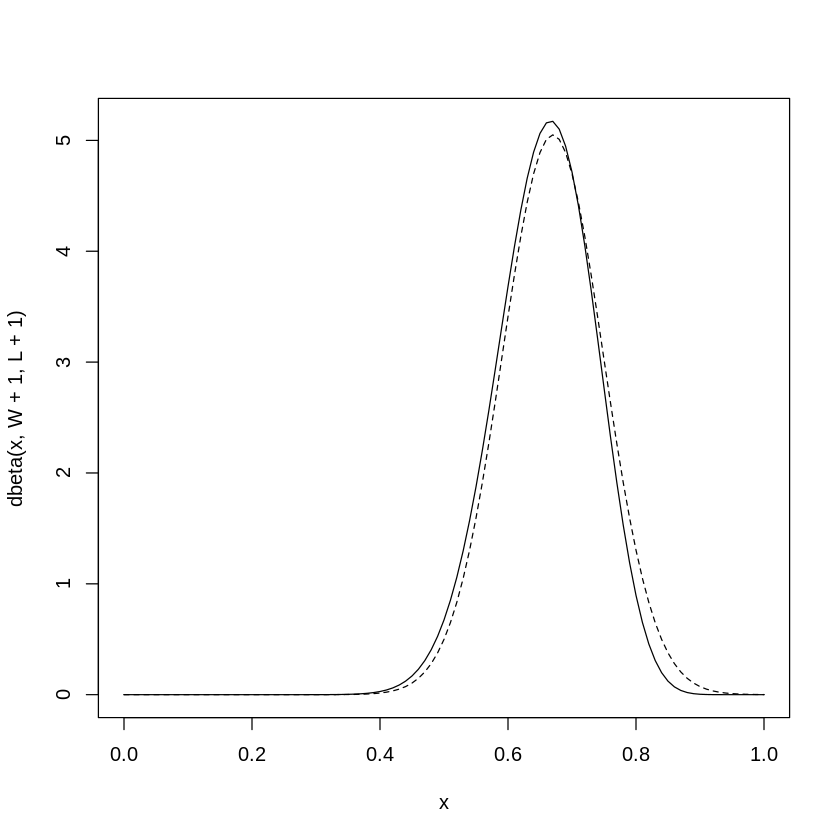

In [7]:
# analytical calculation

N <- 36
W <- N*2/3
L <- N-W
curve( dbeta( x , W+1 , L+1 ) , from=0 , to=1 )     #beta is conjugate prior to binomial distribution

# quadratic approximation
curve( dnorm( x , 0.67 , 0.079 ) , lty=2 , add=TRUE )

In [8]:
n_samples <- 1000
p <- rep( NA , n_samples )
p[1] <- 0.5
W <- 6
L <- 3
for ( i in 2:n_samples ) {
p_new <- rnorm( 1 , p[i-1] , 0.1 )
if ( p_new < 0 ) p_new <- abs( p_new )
if ( p_new > 1 ) p_new <- 2 - p_new
q0 <- dbinom( W , W+L , p[i-1] )
q1 <- dbinom( W , W+L , p_new )
p[i] <- ifelse( runif(1) < q1/q0 , p_new , p[i-1] )
}

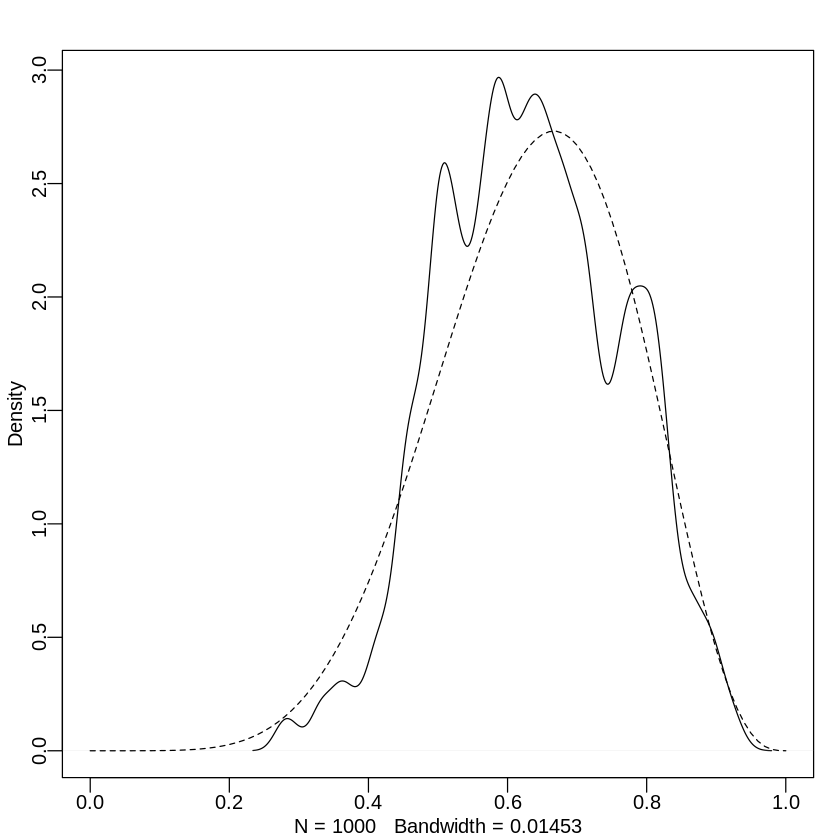

In [9]:
dens( p , xlim=c(0,1) )
curve( dbeta( x , W+1 , L+1 ) , lty=2 , add=TRUE )

Code 3.1

In [10]:
Pr_Positive_Vampire <- 0.95
Pr_Positive_Mortal <- 0.01
Pr_Vampire <- 0.001
Pr_Positive <- Pr_Positive_Vampire * Pr_Vampire +
Pr_Positive_Mortal * ( 1 - Pr_Vampire )
( Pr_Vampire_Positive <- Pr_Positive_Vampire*Pr_Vampire / Pr_Positive )

[1] 0.08683729

Code 3.2

In [11]:
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prob_p <- rep( 1 , 1000 )
prob_data <- dbinom( 6 , size=9 , prob=p_grid )
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)

Code 3.3 to 3.10

In [12]:
samples <- sample( p_grid , prob=posterior , size=1e6 , replace=TRUE )

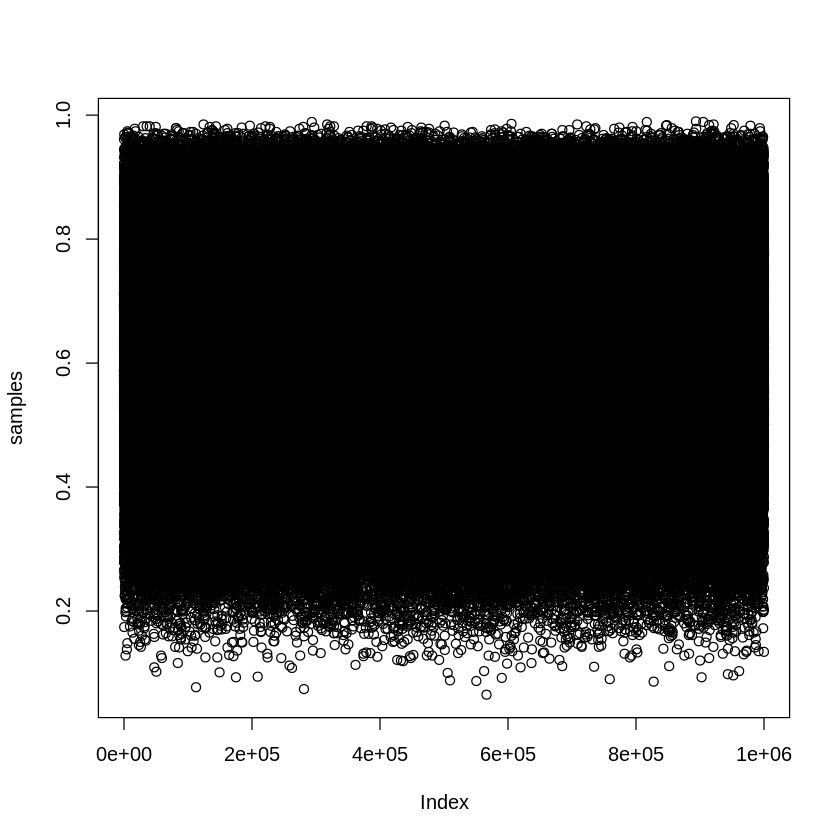

In [13]:
plot( samples )

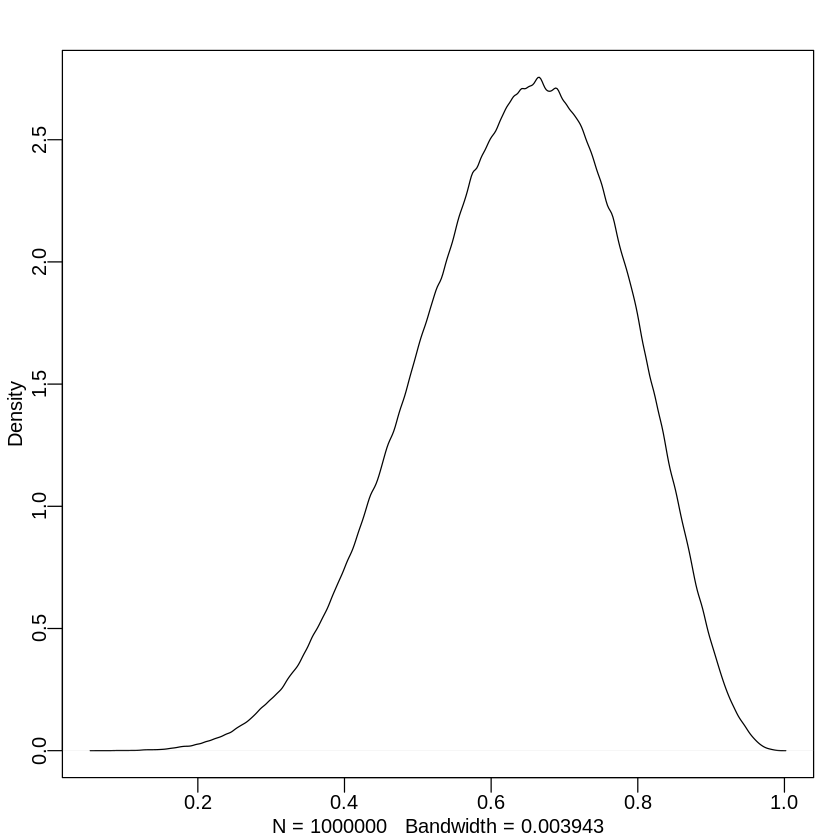

In [14]:
library(rethinking)
dens( samples )

In [15]:
# add up posterior probability where p < 0.5
sum( posterior[ p_grid < 0.5 ] )

[1] 0.1718746

In [16]:
sum( samples < 0.5 ) / length(samples)

[1] 0.171639

In [17]:
sum( samples > 0.5 & samples < 0.75 ) / length(samples)

[1] 0.604295

In [18]:
quantile( samples , 0.8 )

80% 
0.7607608

In [19]:
quantile( samples , c( 0.1 , 0.9 ) )

10%       90% 
0.4484484 0.8128128

Code 3.11 to 3.19

In [20]:
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- rep(1,1000)
likelihood <- dbinom( 3 , size=3 , prob=p_grid )
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample( p_grid , size=1e4 , replace=TRUE , prob=posterior )

In [21]:
PI( samples , prob=0.5 )

25%       75% 
0.7057057 0.9309309

In [22]:
HPDI( samples , prob=0.5 )

|0.5      0.5| 
0.8408408 0.9989990

ROSS: Question - can the HPDI function handle the case where there is more than one peak (e.g. bimodal distribution).  Would it provide several intervals covering the highest posterior densities, or just one continuous interval?

No - read this: https://stackoverflow.com/questions/53671925/highest-density-interval-hdi-for-posterior-distribution-pystan

In [23]:
p_grid[ which.max(posterior) ]

[1] 1

In [24]:
chainmode( samples , adj=0.01 )

[1] 0.9867961

In [25]:
mean( samples )
median( samples )

[1] 0.7994992

[1] 0.8418418

In [26]:
sum( posterior*abs( 0.5 - p_grid ) )

[1] 0.3128752

In [27]:
loss <- sapply( p_grid , function(d) sum( posterior*abs( d - p_grid ) ) )

In [28]:
p_grid[ which.min(loss) ]

[1] 0.8408408

Code 3.20 to 3.24

In [29]:
dbinom( 0:2 , size=2 , prob=0.7 )

[1] 0.09 0.42 0.49

In [30]:
rbinom( 1 , size=2 , prob=0.7 )

[1] 2

In [31]:
rbinom( 10 , size=2 , prob=0.7 )

[1] 2 1 1 2 2 2 0 0 1 2

In [32]:
numSamples = 1e7
dummy_w <- rbinom( numSamples , size=2 , prob=0.7 )
table(dummy_w)/numSamples

dummy_w
        0         1         2 
0.0899282 0.4199551 0.4901167 

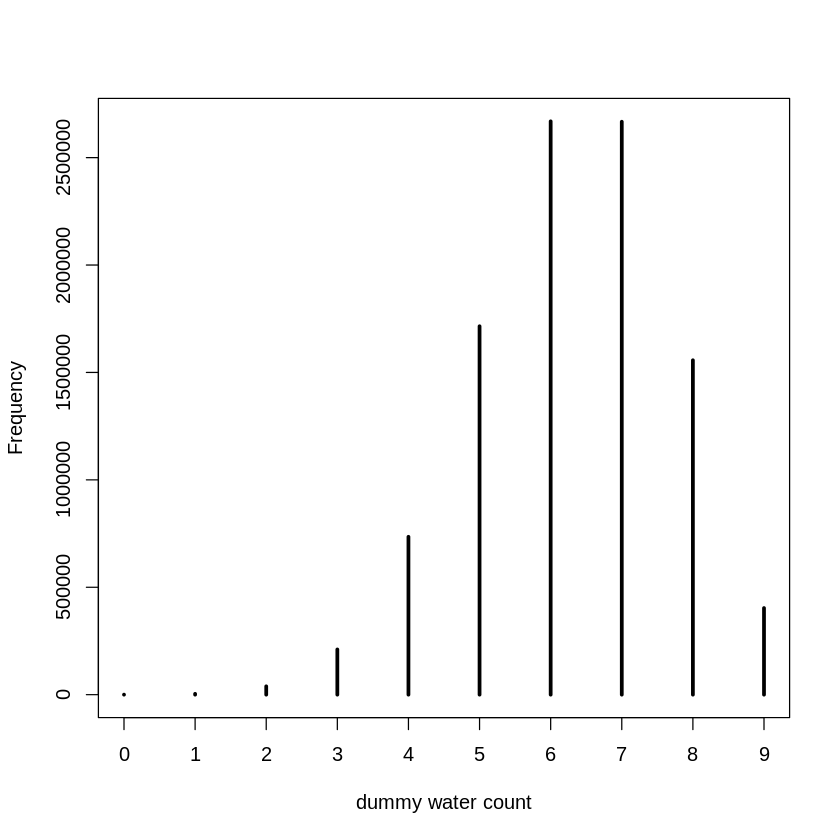

In [33]:
dummy_w <- rbinom( 1e7 , size=9 , prob=0.7 )
simplehist( dummy_w , xlab="dummy water count" )

Code 3.25 to 3.26

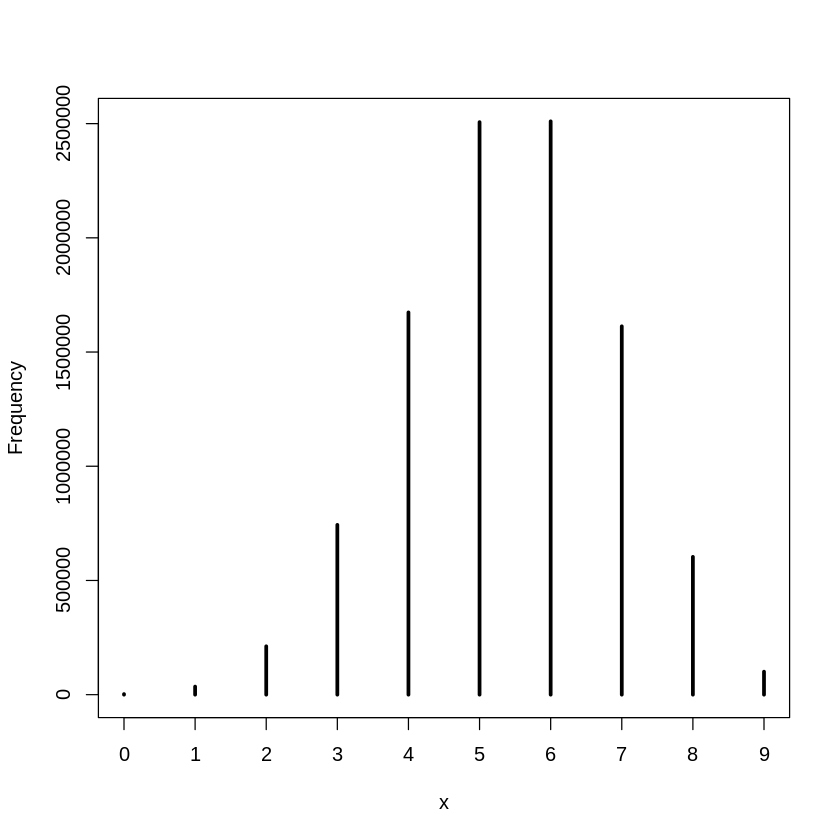

In [34]:
w <- rbinom( 1e7 , size=9 , prob=0.6 )
simplehist(w)

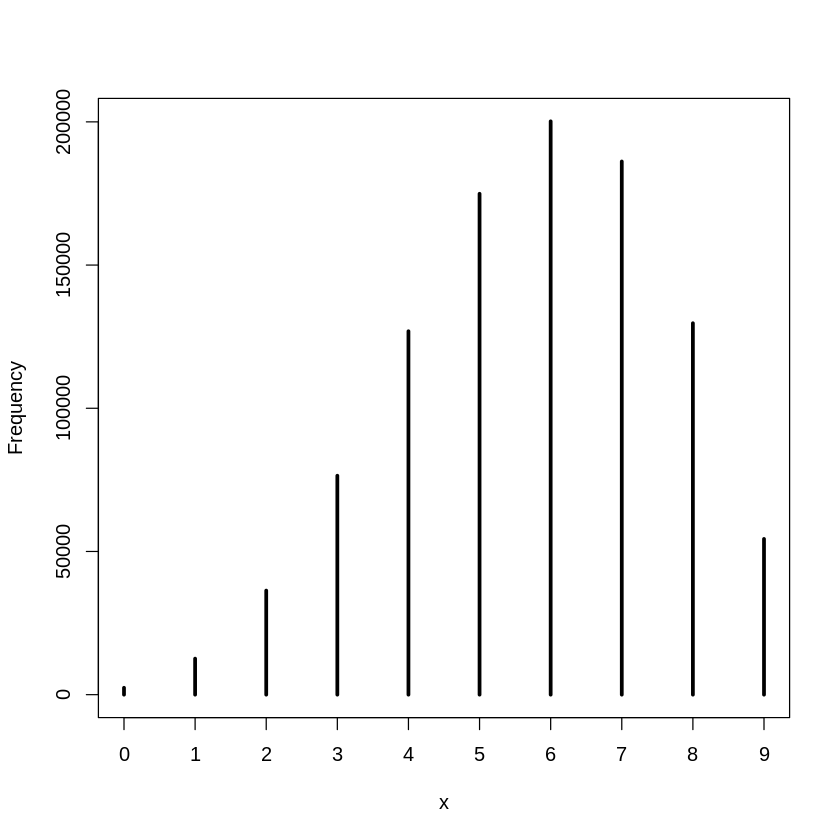

In [35]:
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prob_p <- rep( 1 , 1000 )
prob_data <- dbinom( 6 , size=9 , prob=p_grid )
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)
samples <- sample( p_grid , prob=posterior , size=1e7 , replace=TRUE )

w <- rbinom( 1e6 , size=9 , prob=samples )
simplehist(w)

Practice Questions 3E

In [36]:
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- rep( 1 , 1000 )
likelihood <- dbinom( 6 , size=9 , prob=p_grid )
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
set.seed(100)
samples <- sample( p_grid , prob=posterior , size=1e6 , replace=TRUE )

In [37]:
# add up posterior probability where p < 0.2
sum( posterior[ p_grid < 0.2 ] )
sum( samples < 0.2 ) / length(samples)

[1] 0.0008560951

[1] 0.000871

In [38]:
sum( posterior[ p_grid > 0.8 ] )
sum( samples > 0.8 ) / length(samples)

[1] 0.1203449

[1] 0.120409

In [39]:
sum( posterior[ p_grid >= 0.2 & p_grid <= 0.8])
sum( samples >= 0.2 & samples <= 0.8) / length(samples)

[1] 0.878799

[1] 0.87872

In [40]:
quantile( samples, c(0.2, 0.8) )

20%       80% 
0.5165165 0.7607608

In [41]:
HPDI( samples, 0.66)

|0.66     0.66| 
0.5135135 0.7857858

In [42]:
PI( samples, 0.66)

17%       83% 
0.4984985 0.7747748

Practice Questions 3M

In [43]:
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior_uni <- rep( 1 , 1000 )
likelihood <- dbinom( 8 , size=15 , prob=p_grid )
posterior_uni <- likelihood * prior
posterior_uni <- posterior_uni / sum(posterior_uni)

In [44]:
set.seed(100)
samples_uni <- sample( p_grid , prob=posterior_uni , size=1e6 , replace=TRUE )
HPDI(samples_uni, 0.9)

|0.9      0.9| 
0.3343343 0.7217217

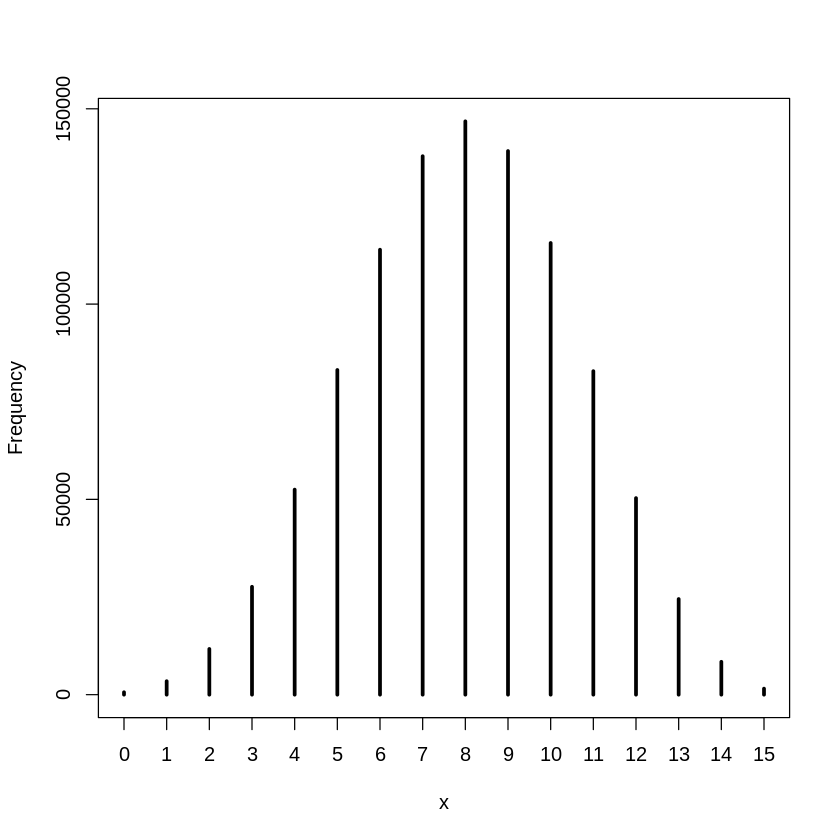

In [45]:
w_uni <- rbinom( 1e6 , size=15 , prob=samples_uni )
simplehist(w_uni)

In [46]:
sum(w_uni == 8)/length(w_uni)

[1] 0.146791

[1] 0.176609

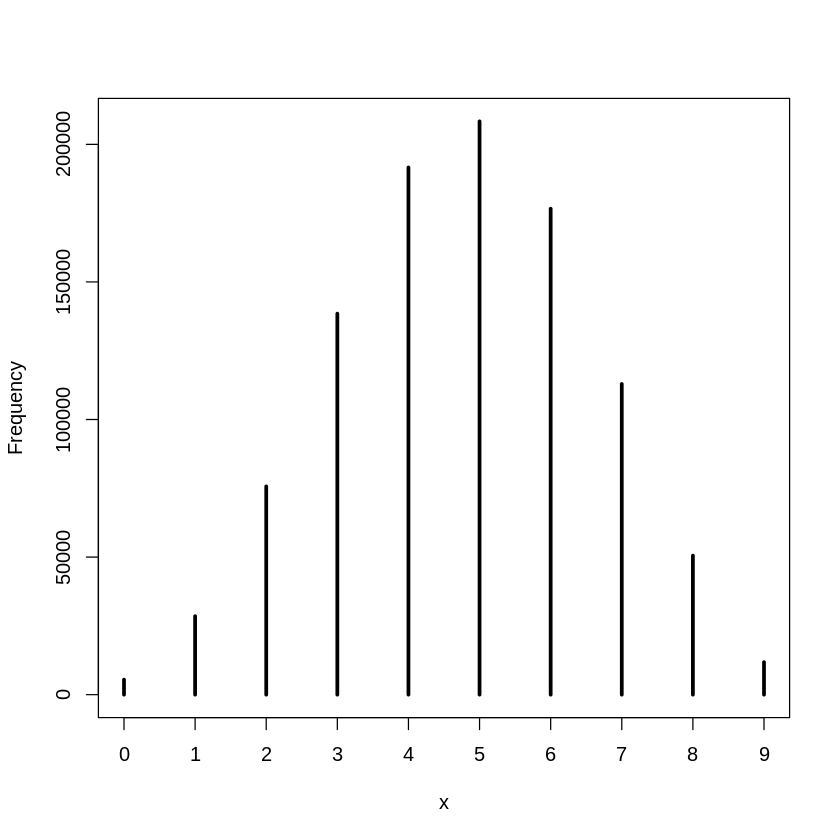

In [47]:
w_9 <- rbinom( 1e6 , size=9 , prob=samples_uni )
sum(w_9 == 6)/length(w_9)
simplehist(w_9)

3M5

In [48]:
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior_trunc <- ifelse( p_grid < 0.5 , 0 , 2 )
likelihood <- dbinom( 8 , size=15 , prob=p_grid )
posterior_trunc <- likelihood * prior_trunc
posterior_trunc <- posterior_trunc / sum(posterior_trunc)

In [49]:
set.seed(100)
samples_trunc <- sample( p_grid , prob=posterior_trunc , size=1e6 , replace=TRUE )
HPDI(samples_trunc, 0.9)

|0.9      0.9| 
0.5005005 0.7117117

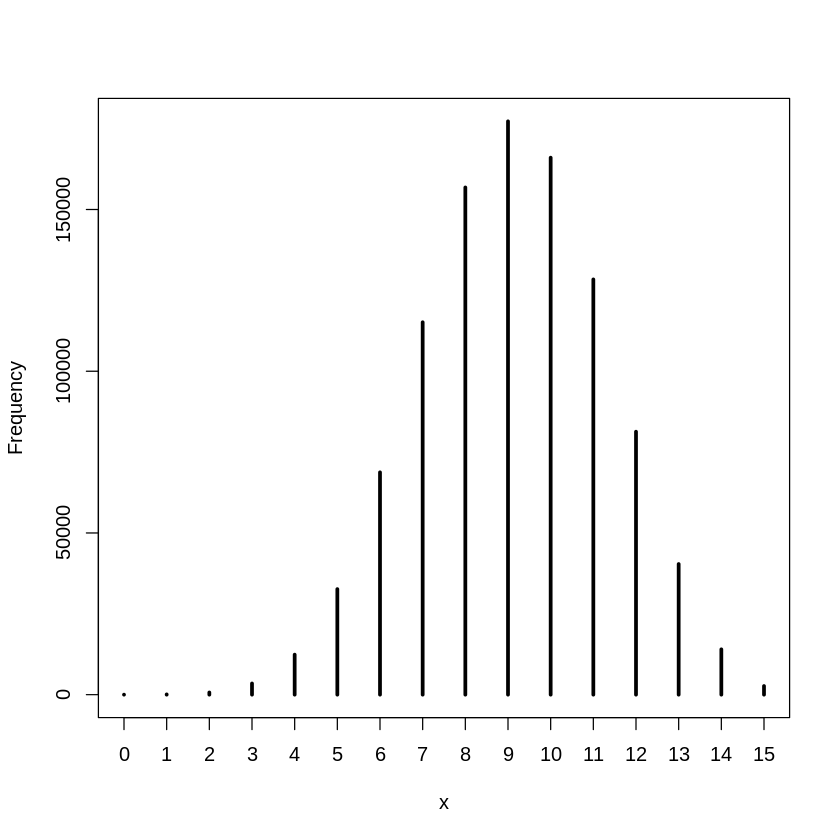

In [50]:
w_trunc <- rbinom( 1e6 , size=15 , prob=samples_trunc )
simplehist(w_trunc)

In [51]:
sum(w_trunc == 8)/length(w_trunc)

[1] 0.156822

[1] 0.231975

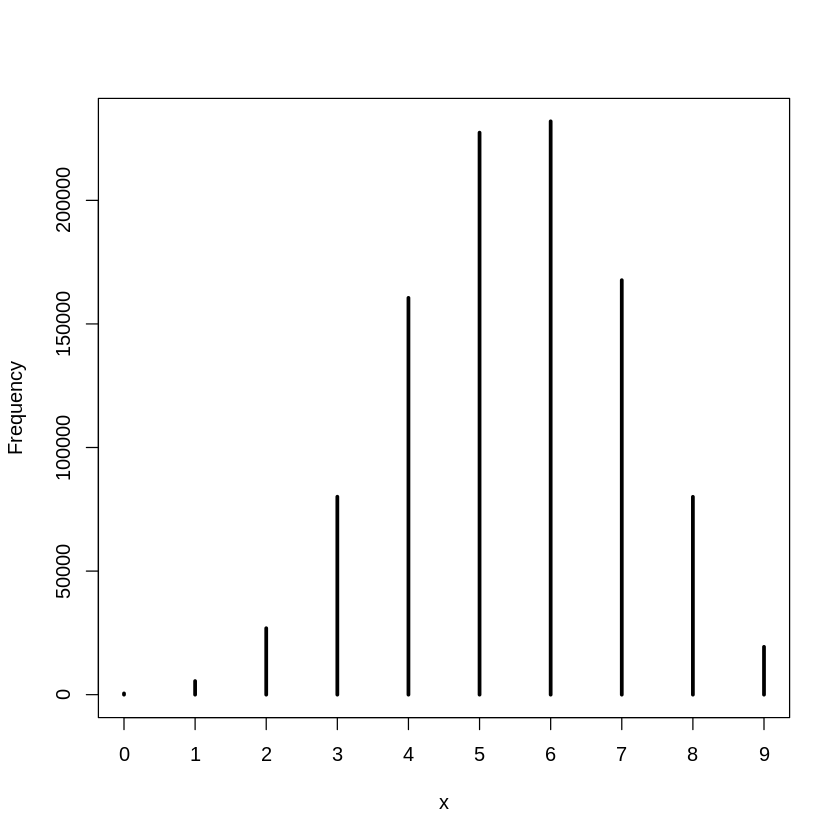

In [52]:
w_9trunc <- rbinom( 1e6 , size=9 , prob=samples_trunc )
sum(w_9trunc == 6)/length(w_9trunc)
simplehist(w_9trunc)

CHAPTER 4

In [53]:
pos <- replicate( 100000 , sum( runif(16,-1,1) ) )

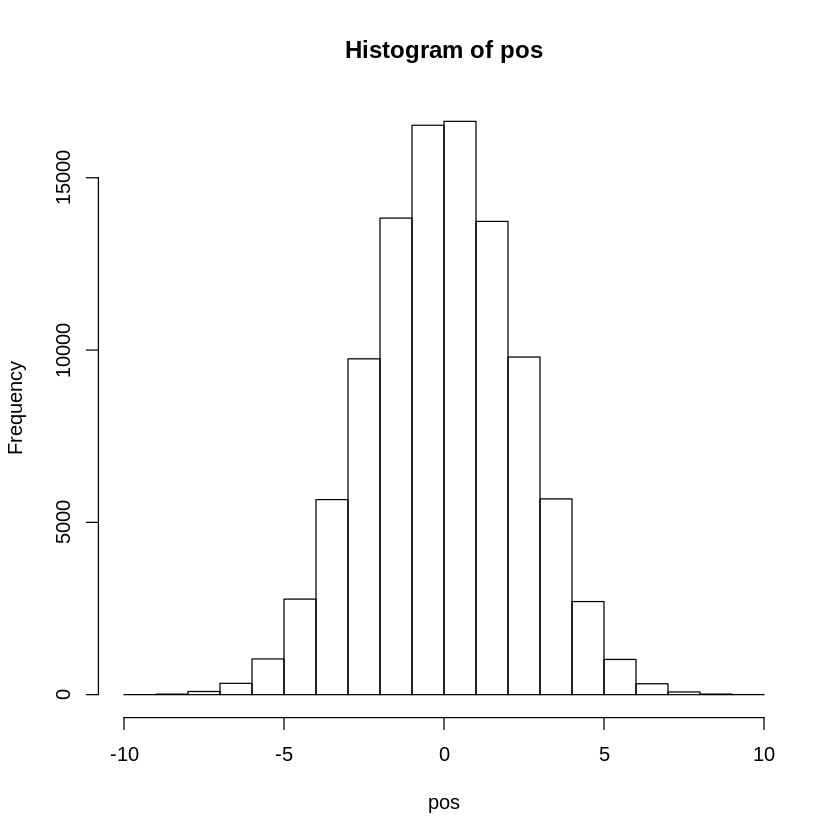

In [54]:
hist(pos)

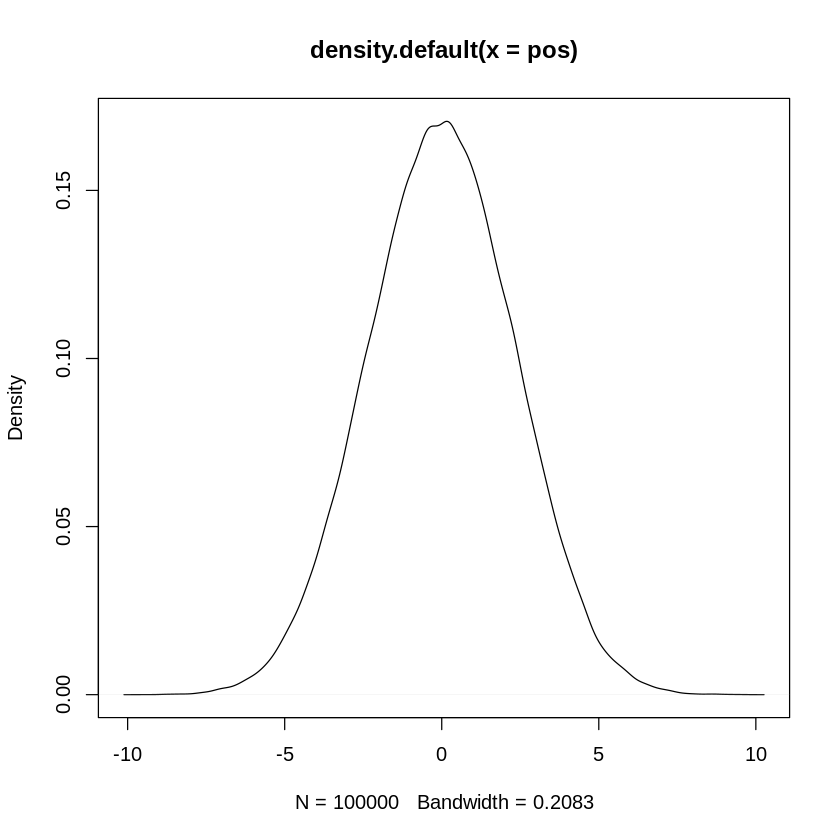

In [55]:
plot(density(pos))

In [56]:
prod( 1 + runif(12,0,0.1) )

[1] 1.686772

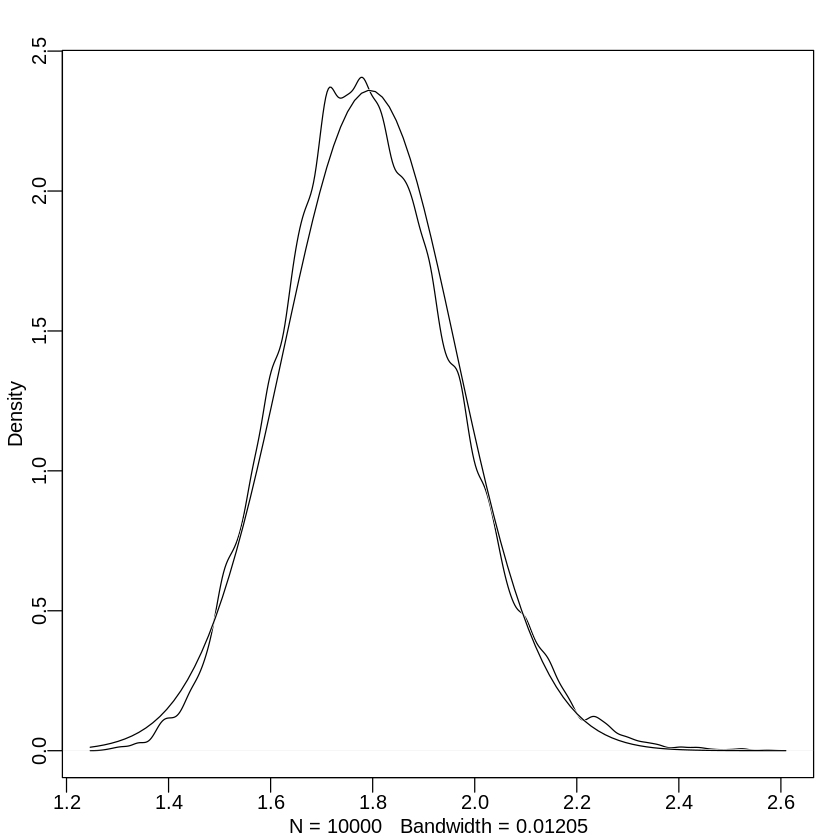

In [57]:
growth <- replicate( 10000 , prod( 1 + runif(12,0,0.1) ) )
dens( growth , norm.comp=TRUE )

In [58]:
big <- replicate( 10000 , prod( 1 + runif(12,0,0.5) ) )
small <- replicate( 10000 , prod( 1 + runif(12,0,0.01) ) )

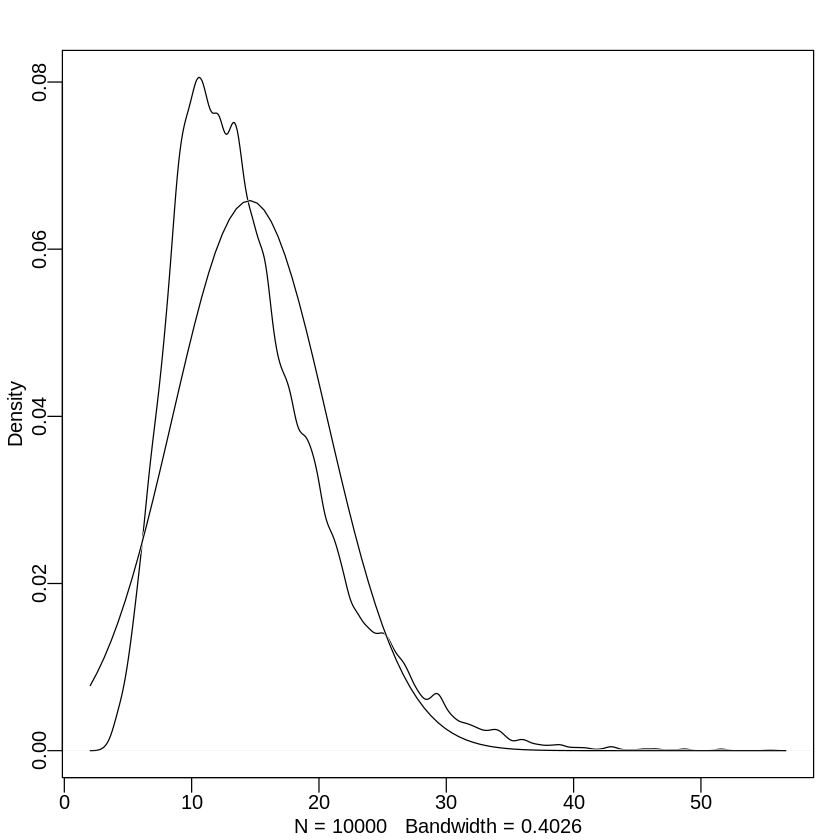

In [59]:
dens( big , norm.comp=TRUE )

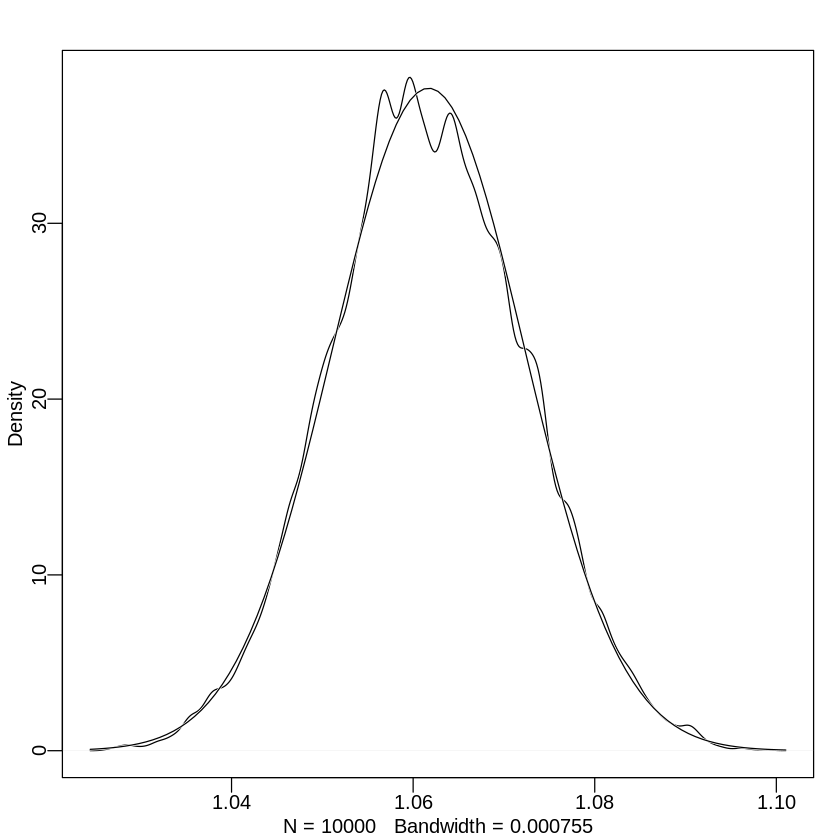

In [60]:
dens( small , norm.comp=TRUE )

In [61]:
log.big <- replicate( 10000 , log(prod(1 + runif(12,0,0.5))) )

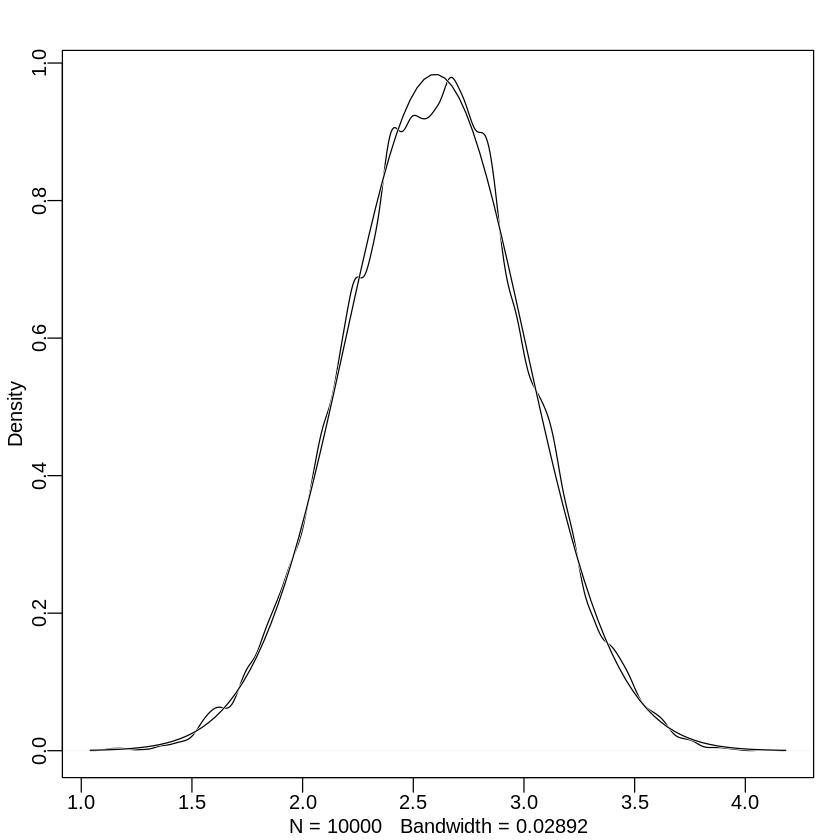

In [62]:
dens( log.big , norm.comp=TRUE )

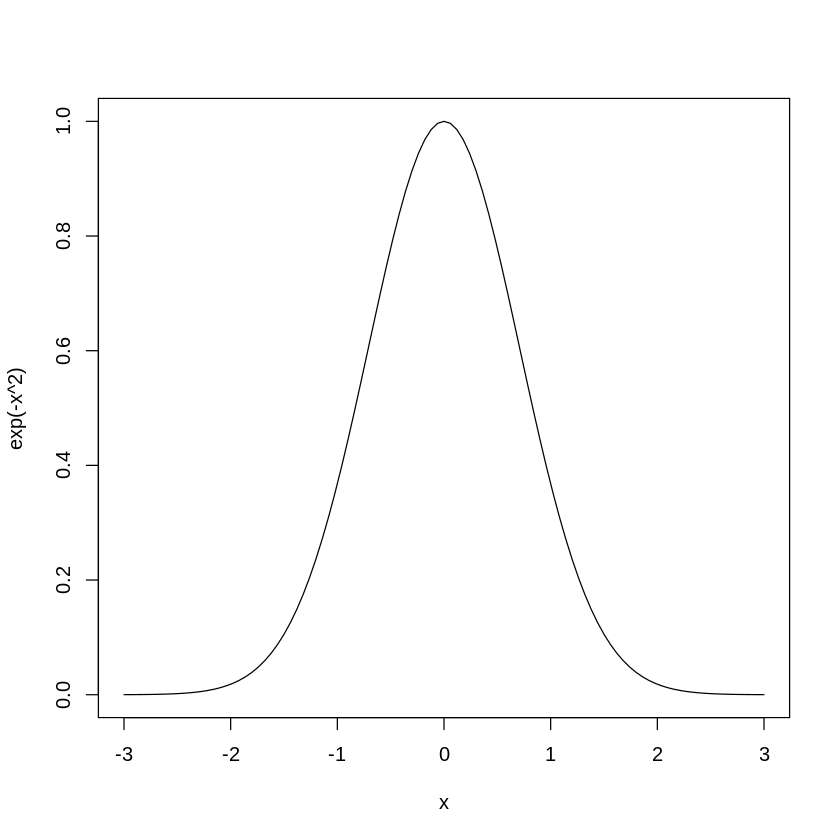

In [63]:
curve( exp( -x^2 ) , from=-3 , to=3 )

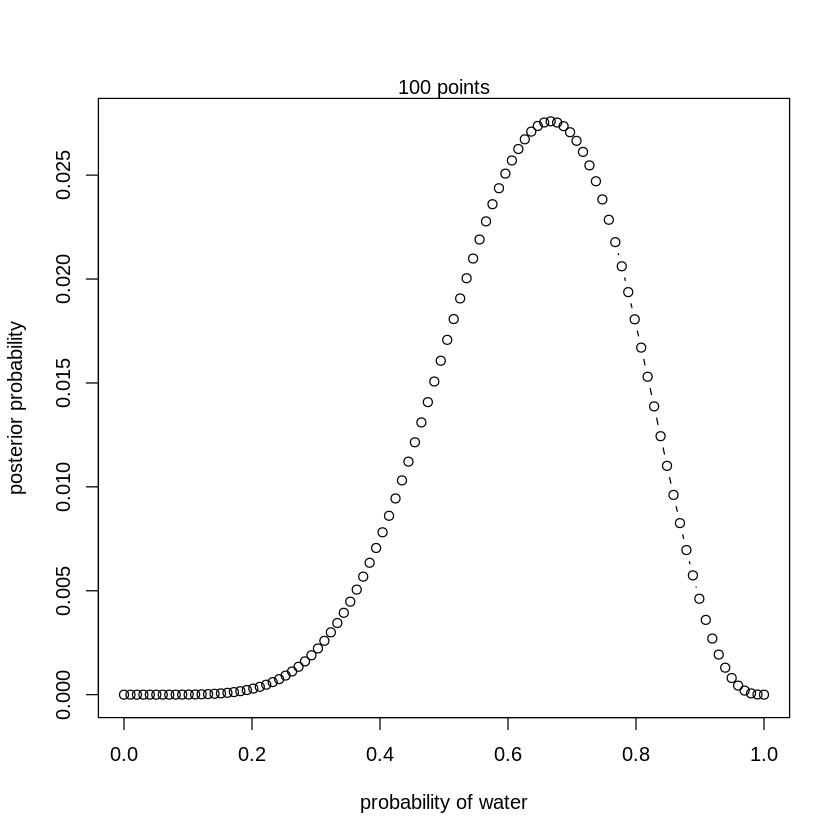

In [64]:
w <- 6; n <- 9; num_points <- 100
p_grid <- seq(from=0,to=1,length.out=num_points)
posterior <- dbinom(w,n,p_grid)*dunif(p_grid,0,1)
posterior <- posterior/sum(posterior)

plot( p_grid , posterior , type="b" , xlab="probability of water" , ylab="posterior probability" )
#mtext("20 points")
mtext(sprintf("%d points", num_points))

In [65]:
library(rethinking)
data(Howell1)
d <- Howell1

In [66]:
str(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


In [67]:
precis( d )

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
height,138.2635963,27.6024476,81.108550,165.73500,▁▁▁▁▁▁▁▂▁▇▇▅▁
weight,35.6106176,14.7191782,9.360721,54.50289,▁▂▃▂▂▂▂▅▇▇▃▂▁
age,29.3443934,20.7468882,1.000000,66.13500,▇▅▅▃▅▂▂▁▁
male,0.4724265,0.4996986,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇


In [68]:
d2 <- d[ d$age >= 18 , ]

In [69]:
precis(d2)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
height,154.59709,7.7423321,142.8750,167.00500,▁▃▇▇▅▇▂▁▁
weight,44.99049,6.4567081,35.1375,55.76588,▁▅▇▇▃▂▁
age,41.13849,15.9678551,20.0000,70.00000,▂▅▇▅▃▇▃▃▂▂▂▁▁▁▁
male,0.46875,0.4997328,0.0000,1.00000,▇▁▁▁▁▁▁▁▁▇


In [70]:
str(d2)

'data.frame':	352 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


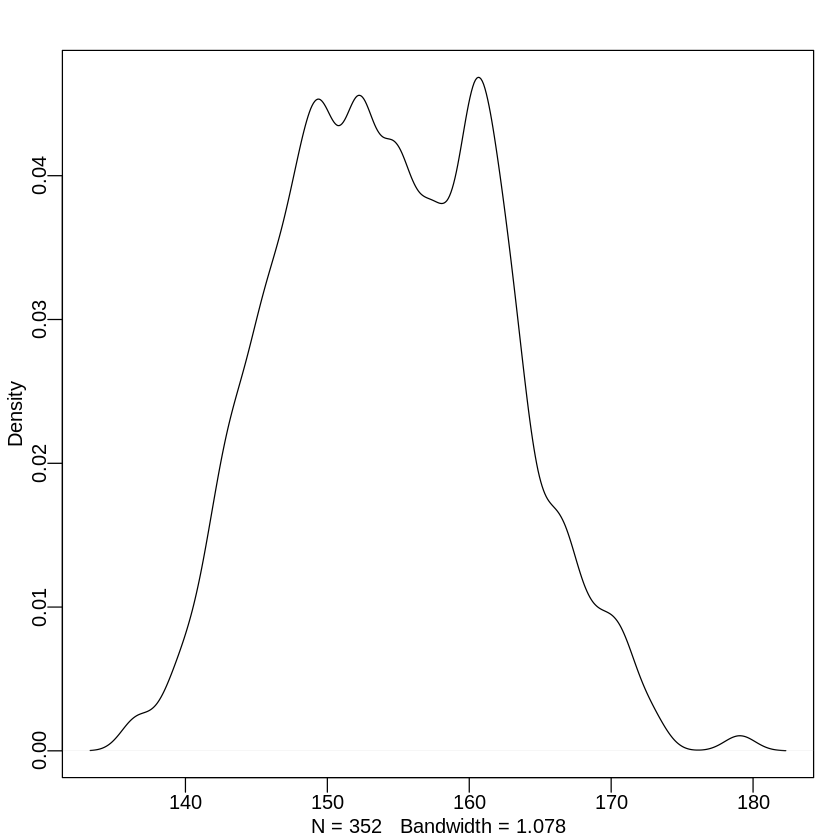

In [71]:
dens(d2$height)

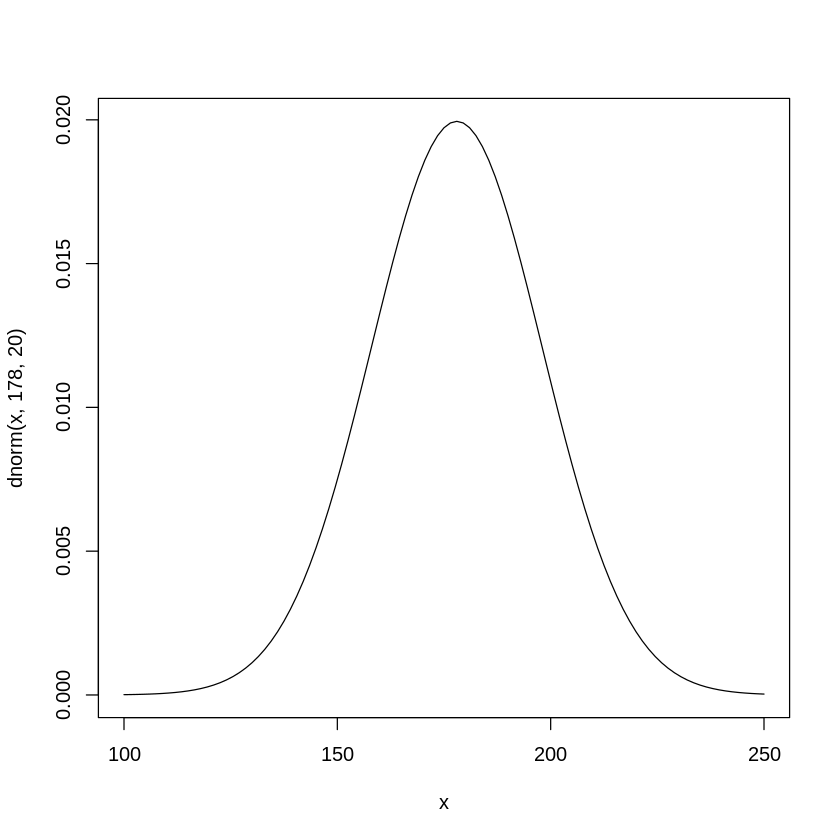

In [72]:
curve( dnorm( x , 178 , 20 ) , from=100 , to=250 )

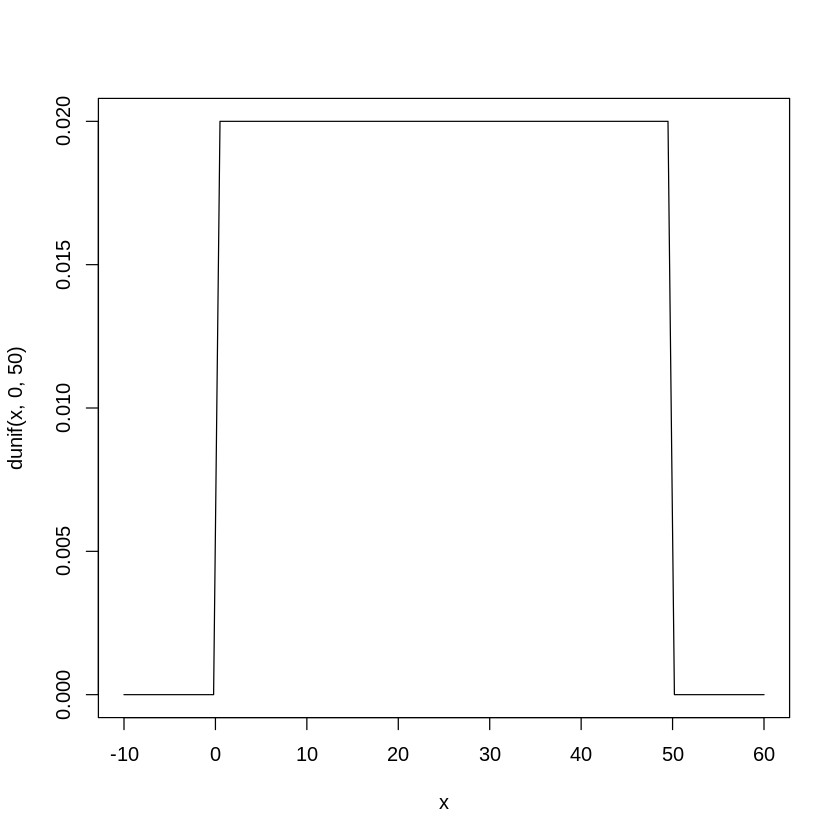

In [73]:
curve( dunif( x , 0 , 50 ) , from=-10 , to=60 )

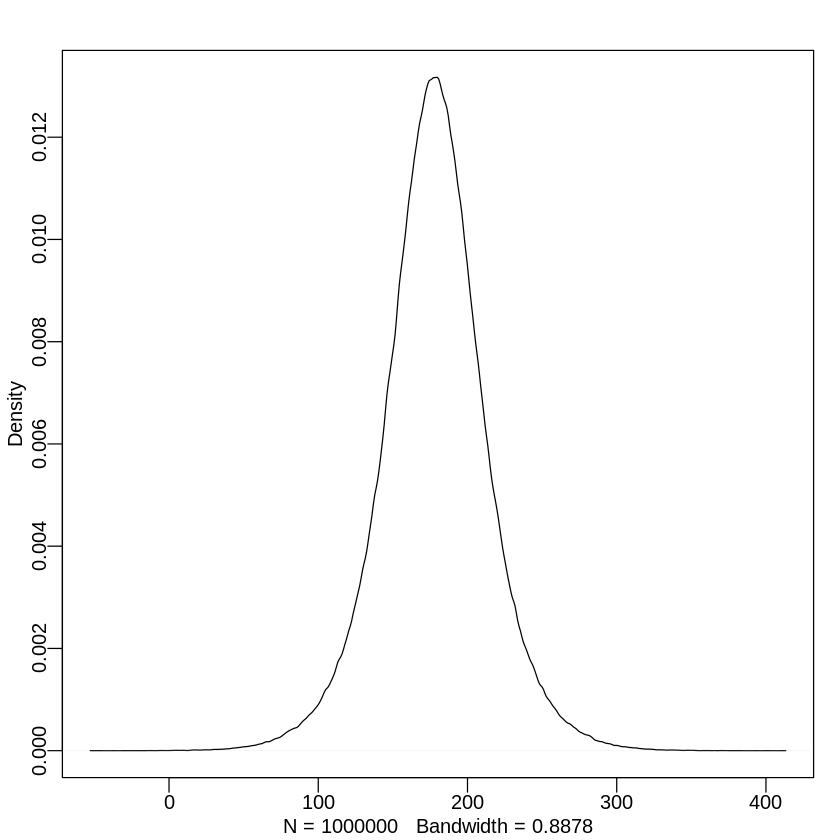

In [74]:
sample_mu <- rnorm( 1e6 , 178 , 20 )
sample_sigma <- runif( 1e6 , 0 , 50 )
prior_h <- rnorm( 1e6 , sample_mu , sample_sigma )
dens( prior_h )

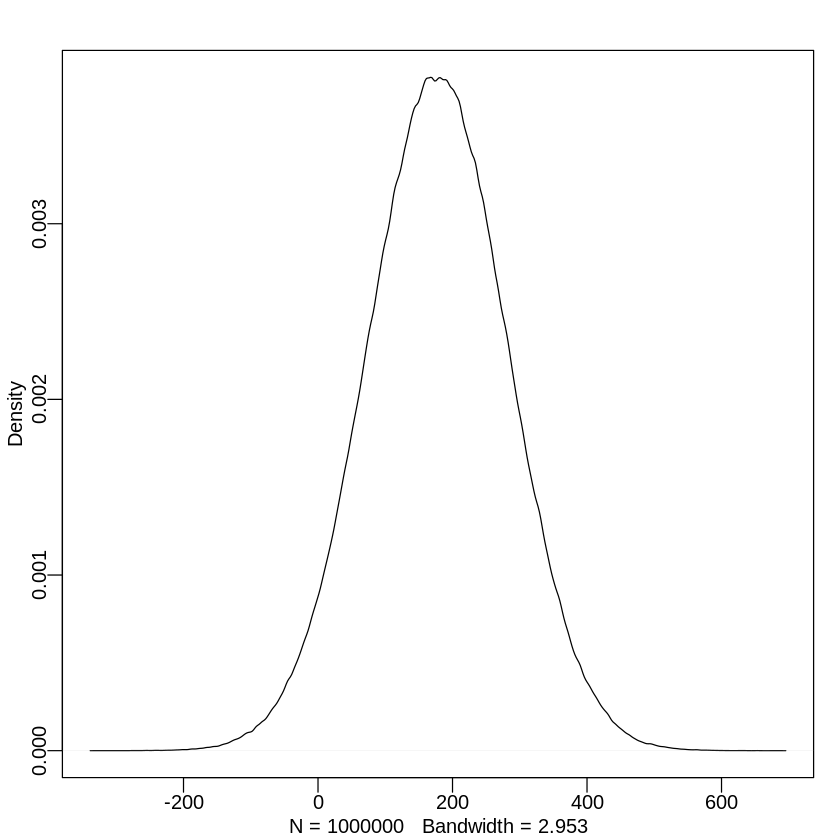

In [75]:
sample_mu <- rnorm( 1e6 , 178 , 100 )
prior_h <- rnorm( 1e6 , sample_mu , sample_sigma )
dens( prior_h )

In [76]:
mu.list <- seq( from=140, to=160 , length.out=200 )
sigma.list <- seq( from=4 , to=9 , length.out=200 )
post <- expand.grid( mu=mu.list , sigma=sigma.list )
post$LL <- sapply( 1:nrow(post) , function(i) sum( dnorm(
d2$height ,
mean=post$mu[i] ,
sd=post$sigma[i] ,
log=TRUE ) ) )
post$prod <- post$LL + dnorm( post$mu , 178 , 20 , TRUE ) +
dunif( post$sigma , 0 , 50 , TRUE )
post$prob <- exp( post$prod - max(post$prod) )

In [77]:
precis(post)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mu,1.500000e+02,5.80251527,141.100,1.589000e+02,▇▇▇▇▇▇▇▇▇▇
sigma,6.500000e+00,1.45062882,4.275,8.725000e+00,▇▇▇▇▇▇▇▇▇▇
LL,-1.534274e+03,384.94341408,-2318.287,-1.226623e+03,▁▁▁▁▁▁▁▁▁▁▁▂▃▇
prod,-1.543123e+03,385.23362800,-2327.670,-1.235118e+03,▁▁▁▁▁▁▁▁▁▁▁▂▃▇
prob,7.545899e-03,0.06100094,0.000,7.487529e-04,▇▁▁▁▁▁▁▁▁▁


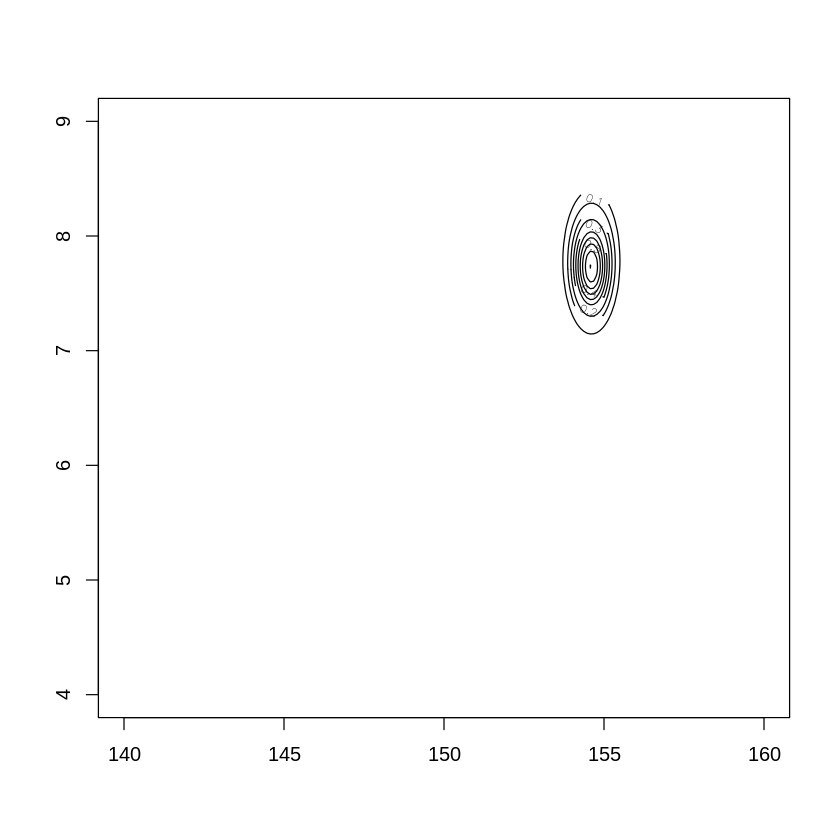

In [78]:
contour_xyz( post$mu , post$sigma , post$prob )

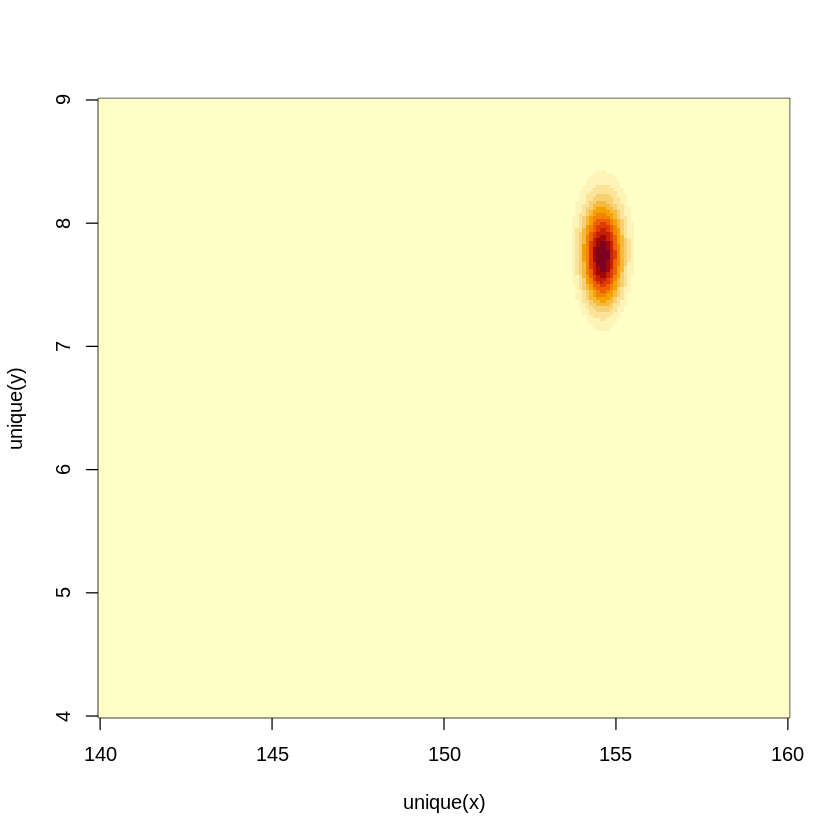

In [79]:
image_xyz( post$mu , post$sigma , post$prob )

In [80]:
sample.rows <- sample( 1:nrow(post) , size=1e4 , replace=TRUE ,
prob=post$prob )
sample.mu <- post$mu[ sample.rows ]
sample.sigma <- post$sigma[ sample.rows ]

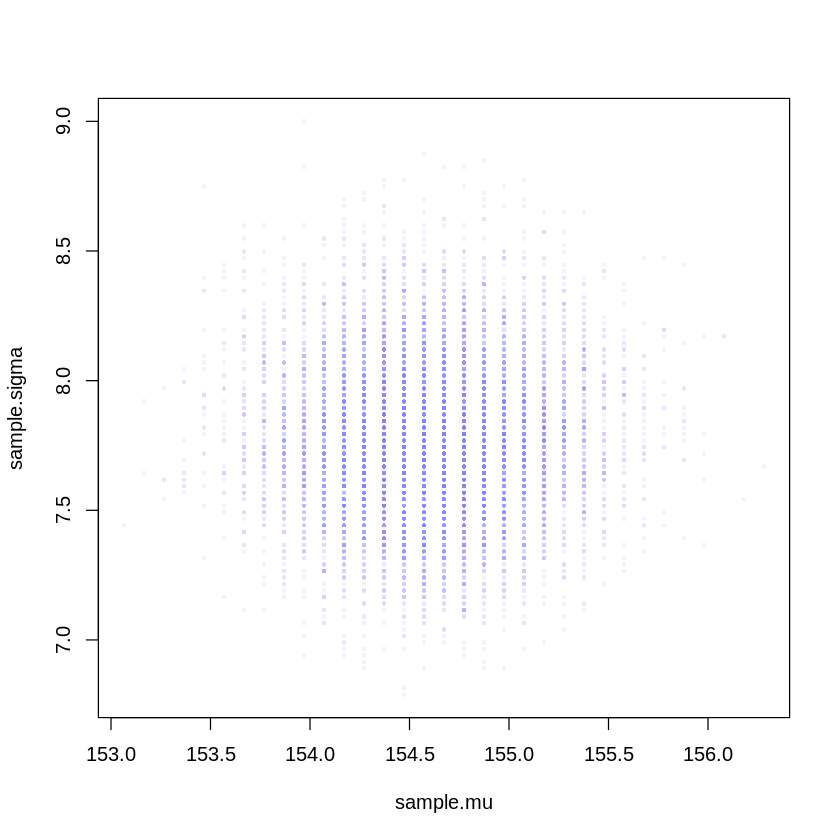

In [81]:
plot( sample.mu , sample.sigma , cex=0.5 , pch=16 , col=col.alpha(rangi2,0.1) )

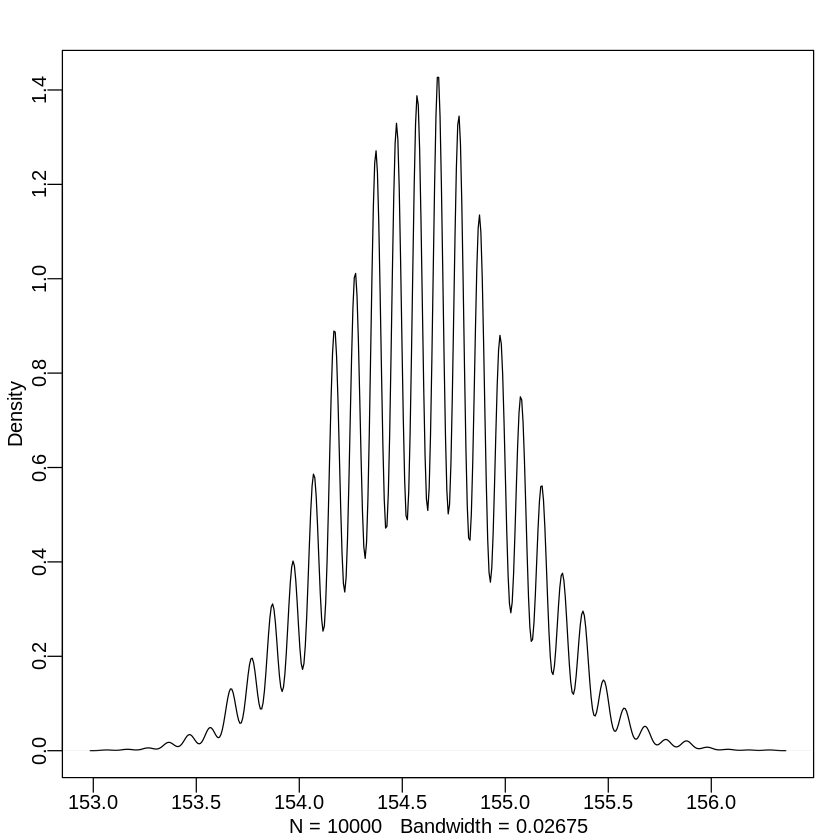

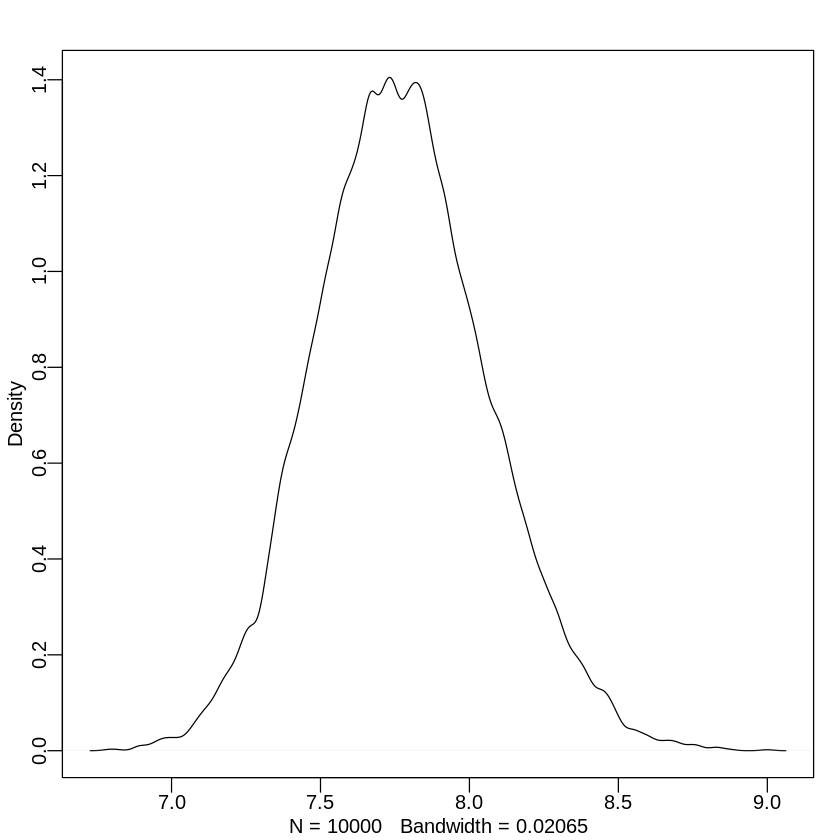

In [82]:
dens( sample.mu )
dens( sample.sigma )

In [83]:
HPDI( sample.mu )
HPDI( sample.sigma )

|0.89    0.89| 
153.8693 155.1759

|0.89    0.89| 
7.341709 8.246231

Code 4.23

In [84]:
d3 <- sample( d2$height , size=20 )

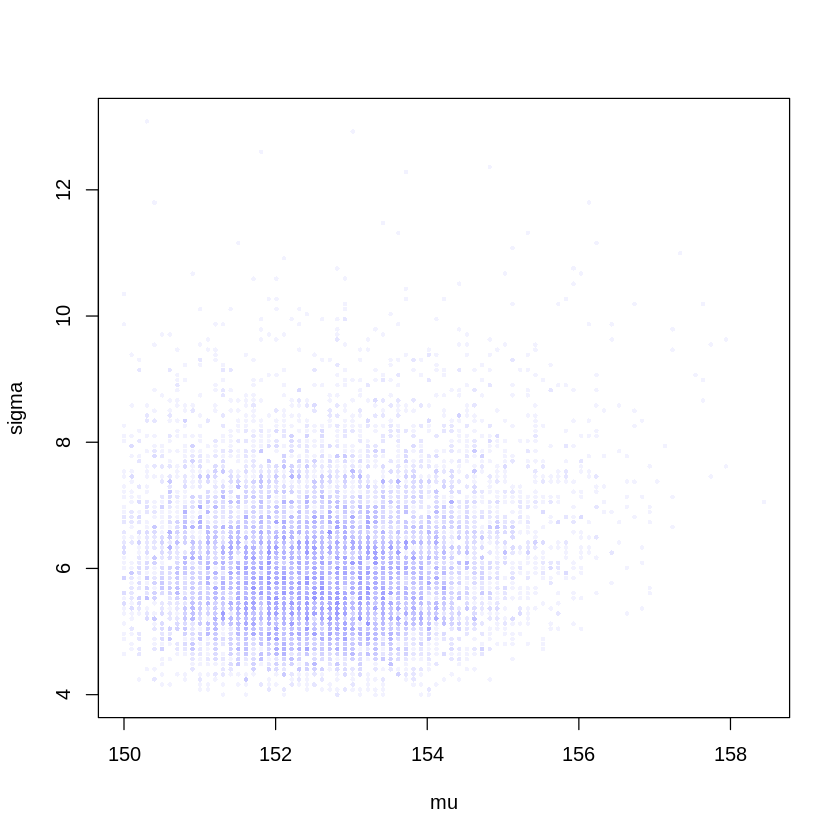

In [85]:
mu.list <- seq( from=150, to=170 , length.out=200 )
sigma.list <- seq( from=4 , to=20 , length.out=200 )
post2 <- expand.grid( mu=mu.list , sigma=sigma.list )
post2$LL <- sapply( 1:nrow(post2) , function(i)
sum( dnorm( d3 , mean=post2$mu[i] , sd=post2$sigma[i] ,
log=TRUE ) ) )
post2$prod <- post2$LL + dnorm( post2$mu , 178 , 20 , TRUE ) +
dunif( post2$sigma , 0 , 50 , TRUE )
post2$prob <- exp( post2$prod - max(post2$prod) )
sample2.rows <- sample( 1:nrow(post2) , size=1e4 , replace=TRUE ,
prob=post2$prob )
sample2.mu <- post2$mu[ sample2.rows ]
sample2.sigma <- post2$sigma[ sample2.rows ]
plot( sample2.mu , sample2.sigma , cex=0.5 ,
col=col.alpha(rangi2,0.1) ,
xlab="mu" , ylab="sigma" , pch=16 )

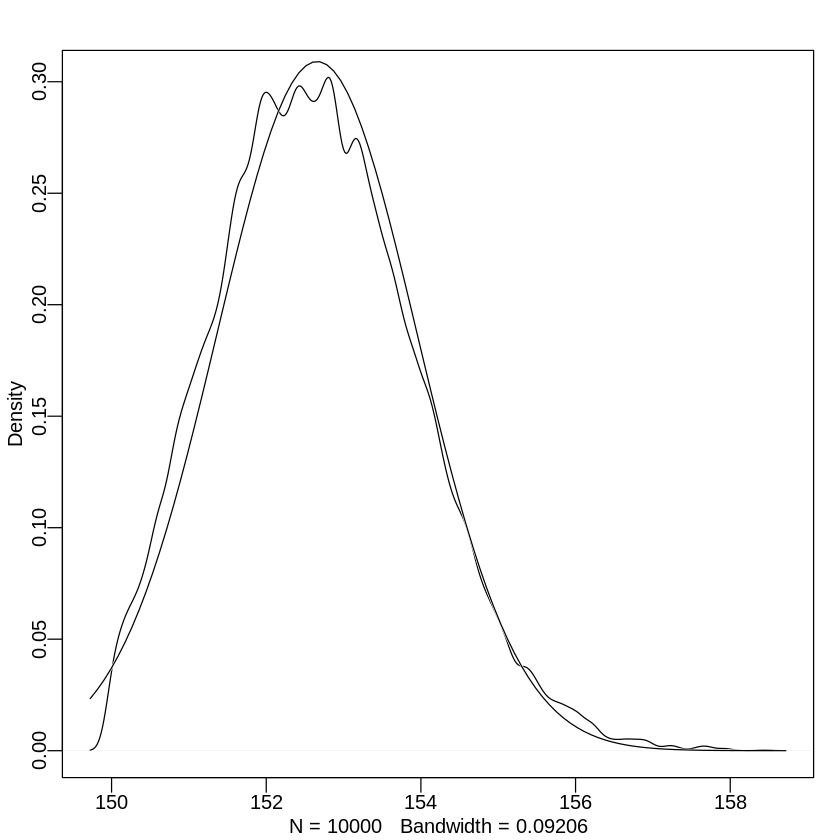

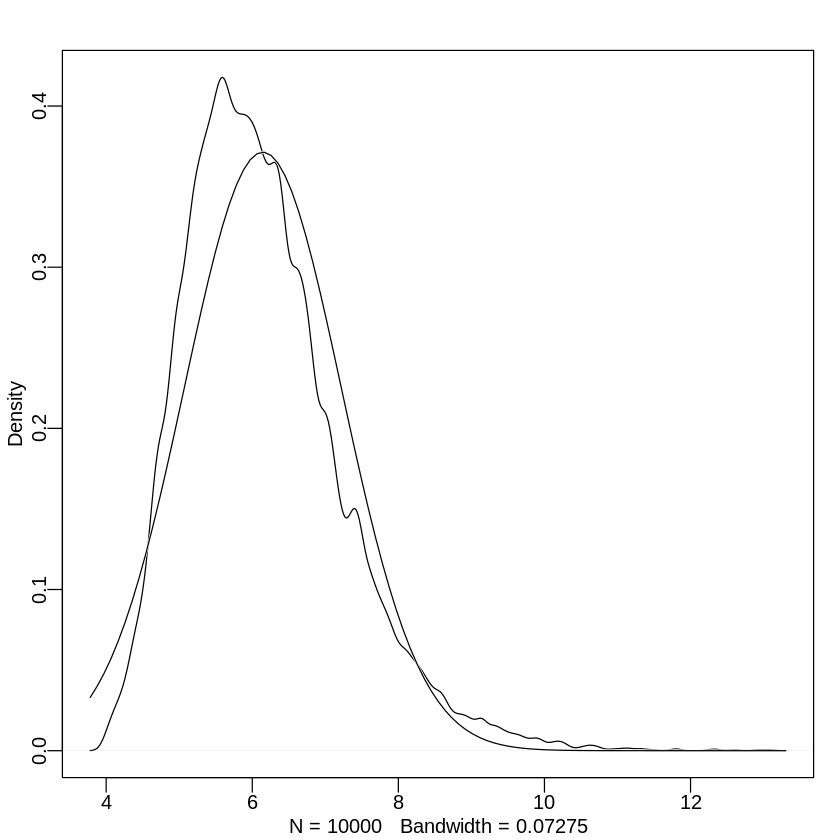

In [86]:
dens( sample2.mu , norm.comp=TRUE )
dens( sample2.sigma , norm.comp=TRUE )

Code 4.26 - Quadratic Approx

In [87]:
library(rethinking)
data(Howell1)
d <- Howell1
d2 <- d[ d$age >= 18 , ]

In [88]:
flist <- alist(
    height ~ dnorm( mu , sigma ) ,
    mu ~ dnorm( 178 , 20 ) ,
    sigma ~ dunif( 0 , 50 )
)

In [89]:
m4.1 <- quap( flist , data=d2 )

In [90]:
precis( m4.1 )

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,154.606969,0.4120216,153.948479,155.265460
sigma,7.731839,0.2914337,7.266072,8.197607


In [91]:
m4.1


Quadratic approximate posterior distribution

Formula:
height ~ dnorm(mu, sigma)
mu ~ dnorm(178, 20)
sigma ~ dunif(0, 50)

Posterior means:
        mu      sigma 
154.606969   7.731839 

Log-likelihood: -1219.41 

In [92]:
str(m4.1)

Formal class 'map' [package "rethinking"] with 10 slots
  ..@ call          : language quap(flist = flist, data = d2)
  ..@ coef          : Named num [1:2] 154.61 7.73
  .. ..- attr(*, "names")= chr [1:2] "mu" "sigma"
  ..@ vcov          : num [1:2, 1:2] 0.169762 0.000217 0.000217 0.084934
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "mu" "sigma"
  .. .. ..$ : chr [1:2] "mu" "sigma"
  ..@ optim         :List of 7
  .. ..$ par        : Named num [1:2] 154.61 7.73
  .. .. ..- attr(*, "names")= chr [1:2] "mu" "sigma"
  .. ..$ value      : num 1228
  .. ..$ counts     : Named int [1:2] 24 12
  .. .. ..- attr(*, "names")= chr [1:2] "function" "gradient"
  .. ..$ convergence: int 0
  .. ..$ message    : NULL
  .. ..$ hessian    : num [1:2, 1:2] 5.891 -0.015 -0.015 11.774
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:2] "mu" "sigma"
  .. .. .. ..$ : chr [1:2] "mu" "sigma"
  .. ..$ minuslogl  : num 1219
  ..@ data          :List of 4
  .. ..$ height: num [

In [93]:
start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

In [94]:
m4.2 <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu ~ dnorm( 178 , 0.1 ) ,
        sigma ~ dunif( 0 , 50 )
    ) , data=d2 )
precis( m4.2 )

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,177.8638,0.1002354,177.70357,178.02396
sigma,24.5178,0.9289452,23.03316,26.00243


In [95]:
vcov( m4.1 )

,mu,sigma
mu,0.1697396109,0.0002180307
sigma,0.0002180307,0.0849058224


In [96]:
diag( vcov( m4.1 ) )
cov2cor( vcov( m4.1 ) )

mu      sigma 
0.16973961 0.08490582

,mu,sigma
mu,1.000000000,0.001816174
sigma,0.001816174,1.000000000


In [97]:
library(rethinking)
post <- extract.samples( m4.1 , n=1e4 )
head(post)

mu,sigma
<dbl>,<dbl>
155.1172,7.797121
154.0127,7.585902
154.9624,7.675566
153.8783,7.450231
154.6484,7.637127
155.3469,7.666954


In [98]:
precis(post)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mu,154.611060,0.4096550,153.954055,155.267248,▁▁▅▇▂▁▁
sigma,7.729595,0.2930745,7.259279,8.193587,▁▁▁▂▅▇▇▃▁▁▁▁


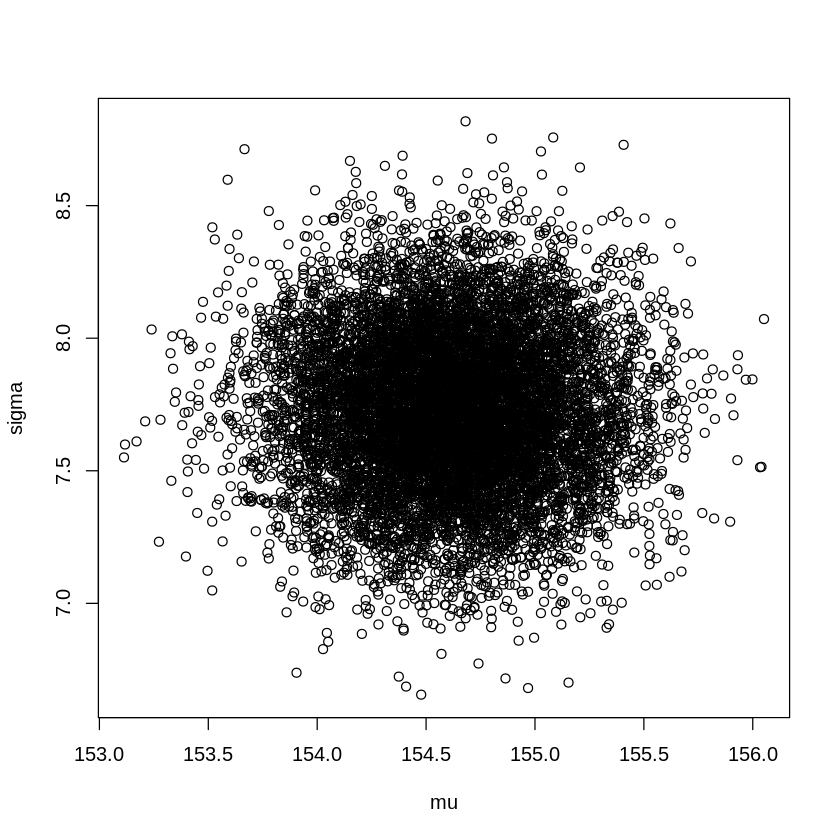

In [99]:
plot(post)

Code 4.37

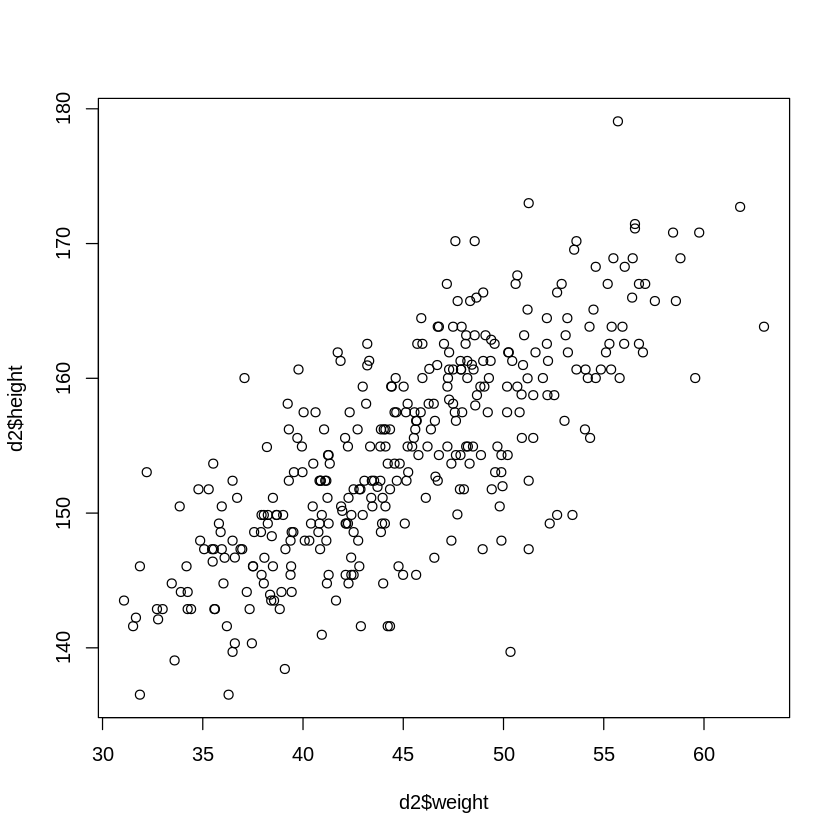

In [100]:
plot( d2$height ~ d2$weight )

In [101]:
set.seed(2971)
N <- 100
# 100 lines
a <- rnorm( N , 178 , 20 )
b <- rnorm( N , 0 , 10 )

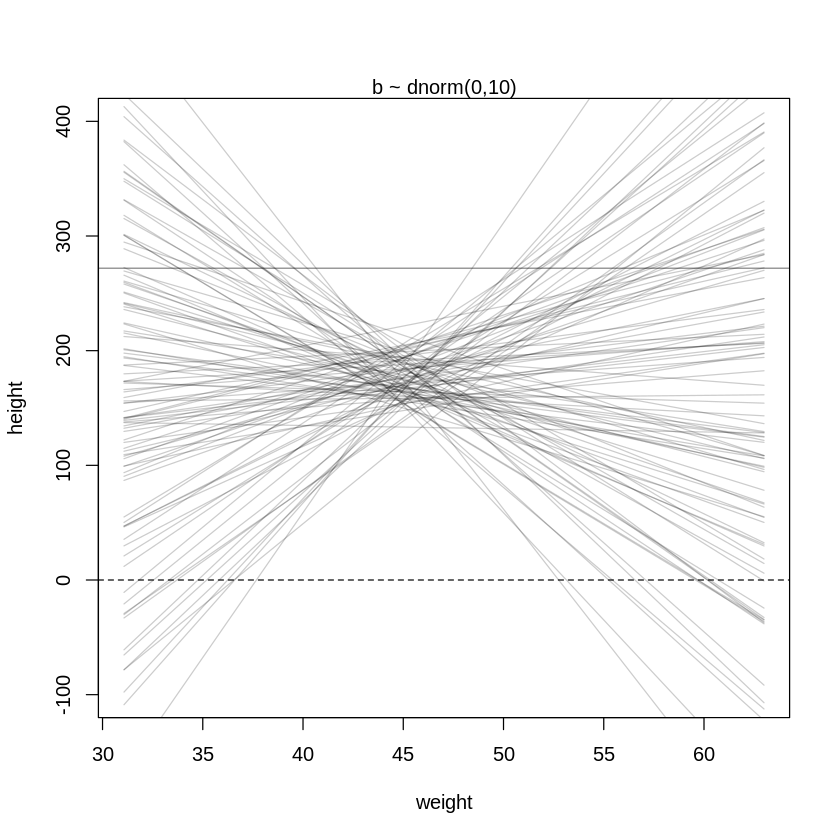

In [102]:
plot( NULL , xlim=range(d2$weight) , ylim=c(-100,400) ,
xlab="weight" , ylab="height" )
abline( h=0 , lty=2 )
abline( h=272 , lty=1 , lwd=0.5 )
mtext( "b ~ dnorm(0,10)" )
xbar <- mean(d2$weight)
for ( i in 1:N ) curve( a[i] + b[i]*(x - xbar) ,
from=min(d2$weight) , to=max(d2$weight) , add=TRUE ,
col=col.alpha("black",0.2) )

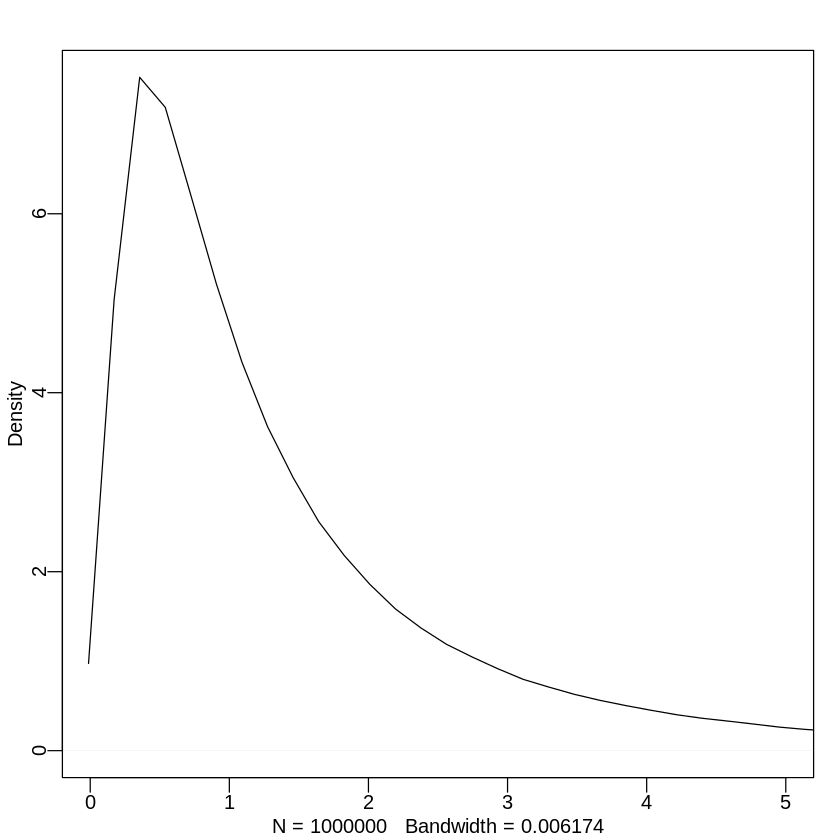

In [103]:
b <- rlnorm( 1e6 , 0 , 1 )
dens( b , xlim=c(0,5) , adj=0.1 )

In [104]:
set.seed(2971)
N <- 100
# 100 lines
a <- rnorm( N , 178 , 20 )
b <- rlnorm( N , 0 , 1 )

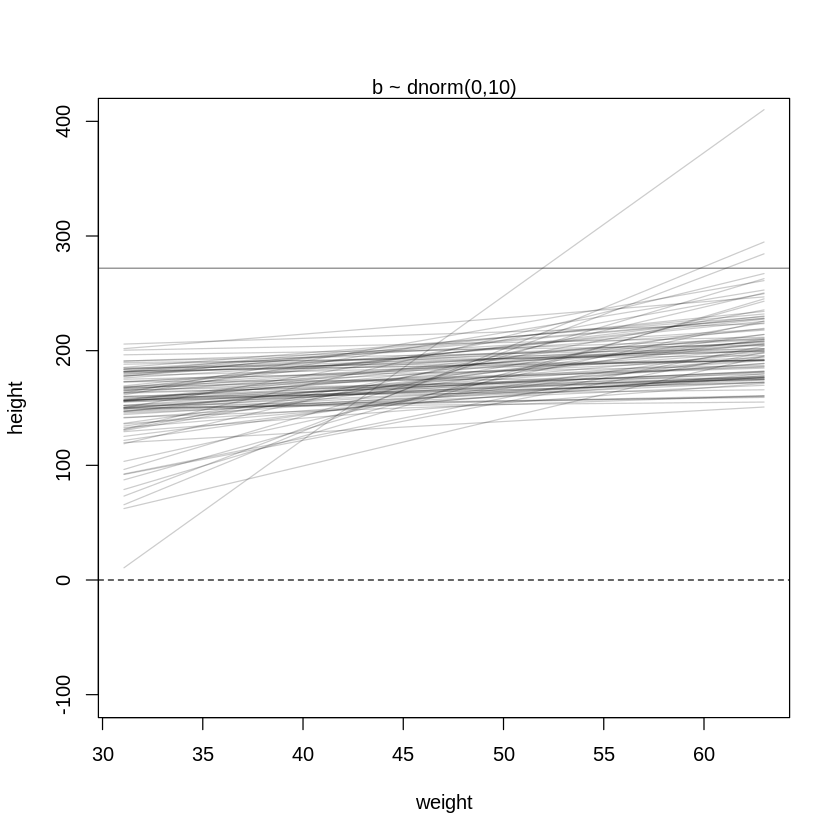

In [105]:
plot( NULL , xlim=range(d2$weight) , ylim=c(-100,400) ,
xlab="weight" , ylab="height" )
abline( h=0 , lty=2 )
abline( h=272 , lty=1 , lwd=0.5 )
mtext( "b ~ dnorm(0,10)" )
xbar <- mean(d2$weight)
for ( i in 1:N ) curve( a[i] + b[i]*(x - xbar) ,
from=min(d2$weight) , to=max(d2$weight) , add=TRUE ,
col=col.alpha("black",0.2) )

Code 4.42

In [106]:
# load data again, since it's a long way back
library(rethinking)
data(Howell1)
d <- Howell1
d2 <- d[ d$age >= 18 , ]

# define the average weight, x-bar
xbar <- mean(d2$weight)

# fit model
m4.3 <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + b*( weight - xbar ) ,
        a ~ dnorm( 178 , 20 ) ,
        b ~ dlnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 50 )
    ) ,
    data=d2 )

In [107]:
precis( m4.3 )

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,154.6013671,0.27030766,154.1693633,155.0333710
b,0.9032807,0.04192363,0.8362787,0.9702828
sigma,5.0718809,0.19115478,4.7663786,5.3773831


In [108]:
vcov( m4.3 )

,a,b,sigma
a,7.306623e-02,-4.244613e-08,6.157960e-05
b,-4.244613e-08,1.757591e-03,-2.518671e-05
sigma,6.157960e-05,-2.518671e-05,3.654015e-02


In [109]:
round( vcov( m4.3 ) , 3 )

,a,b,sigma
a,0.073,0.000,0.000
b,0.000,0.002,0.000
sigma,0.000,0.000,0.037


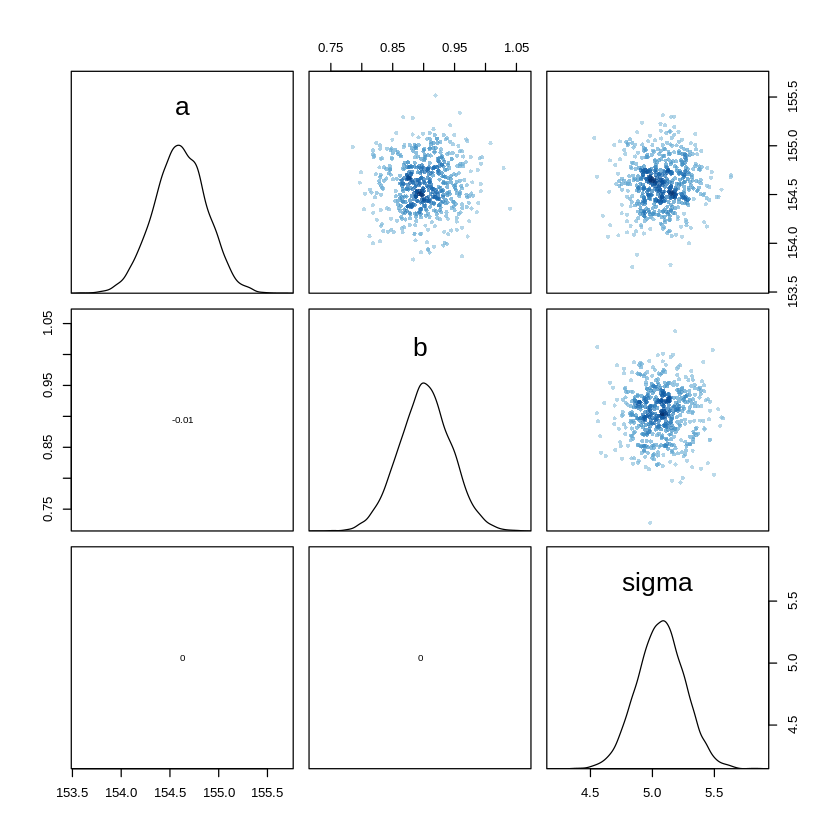

In [110]:
pairs(m4.3)

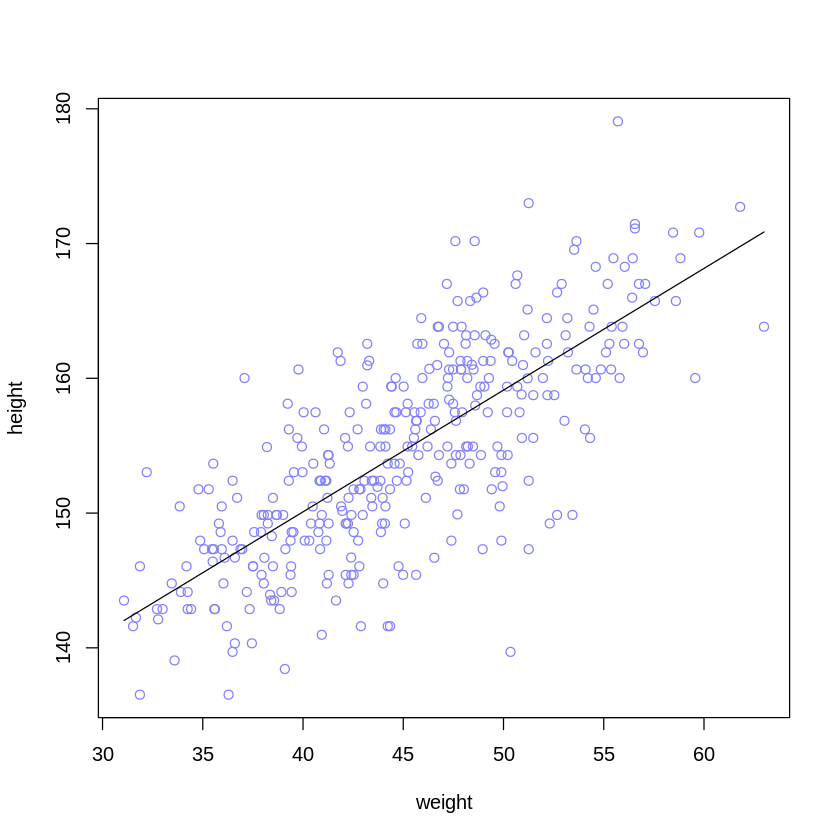

In [111]:
plot( height ~ weight , data=d2 , col=rangi2 )
post <- extract.samples( m4.3 )
a_map <- mean(post$a)
b_map <- mean(post$b)
curve( a_map + b_map*(x - xbar) , add=TRUE )

In [112]:
post <- extract.samples( m4.3 )
post[1:5,]

a,b,sigma
<dbl>,<dbl>,<dbl>
154.5789,0.9376825,5.220756
154.4067,0.8937310,4.752735
154.4622,0.9150822,5.341227
154.2649,0.9236067,5.160423
155.1258,0.9495934,5.108891


In [113]:
N <- 10
dN <- d2[ 1:N , ]
mN <- quap(
alist(
    height ~ dnorm( mu , sigma ) ,
    mu <- a + b*( weight - mean(weight) ) ,
    a ~ dnorm( 178 , 20 ) ,
    b ~ dlnorm( 0 , 1 ) ,
    sigma ~ dunif( 0 , 50 )
    ) , data=dN )

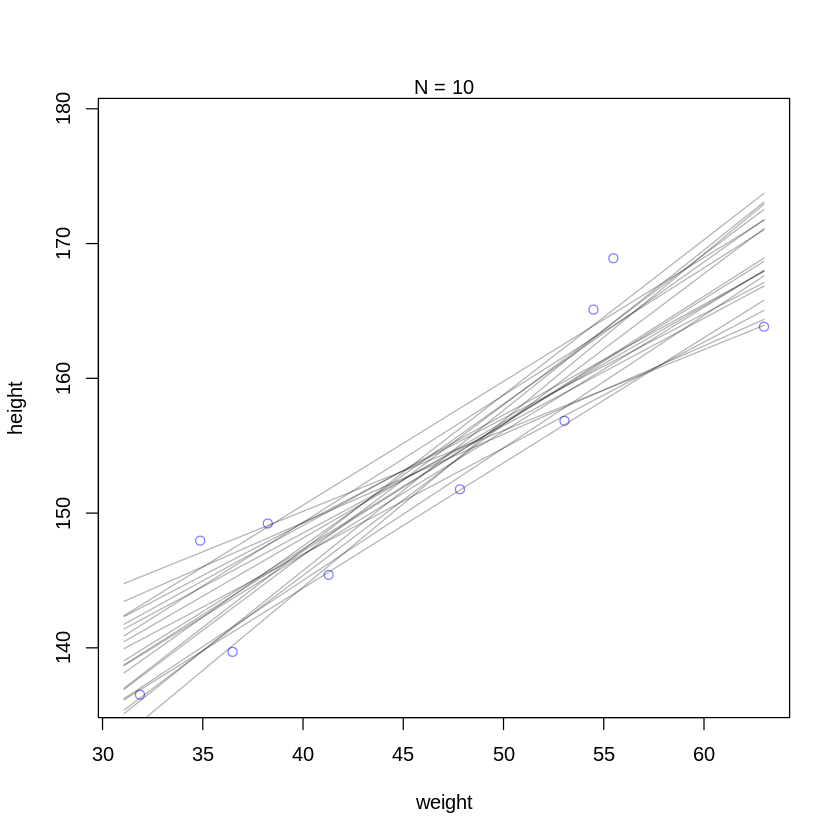

In [114]:
# extract 20 samples from the posterior
post <- extract.samples( mN , n=20 )

# display raw data and sample size
plot( dN$weight , dN$height ,
xlim=range(d2$weight) , ylim=range(d2$height) ,
col=rangi2 , xlab="weight" , ylab="height" )
mtext(concat("N = ",N))

# plot the lines, with transparency
for ( i in 1:20 )
    curve( post$a[i] + post$b[i]*(x-mean(dN$weight)) ,
      col=col.alpha("black",0.3) , add=TRUE )

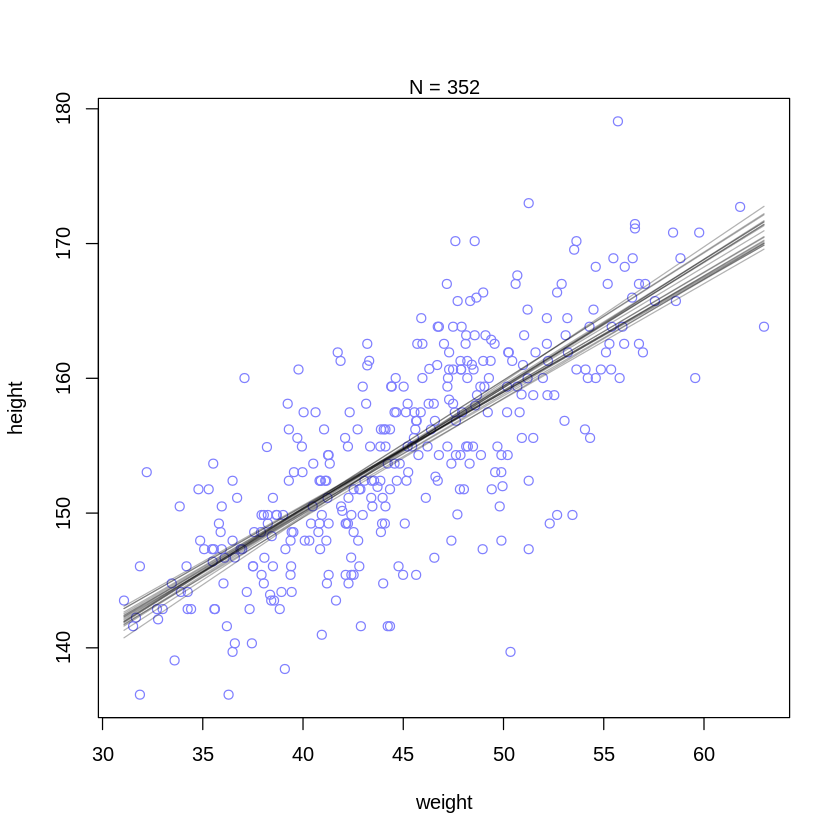

In [115]:
N <- 352
dN <- d2[ 1:N , ]
mN <- quap(
alist(
    height ~ dnorm( mu , sigma ) ,
    mu <- a + b*( weight - mean(weight) ) ,
    a ~ dnorm( 178 , 20 ) ,
    b ~ dlnorm( 0 , 1 ) ,
    sigma ~ dunif( 0 , 50 )
    ) , data=dN )

# extract 20 samples from the posterior
post <- extract.samples( mN , n=20 )

# display raw data and sample size
plot( dN$weight , dN$height ,
xlim=range(d2$weight) , ylim=range(d2$height) ,
col=rangi2 , xlab="weight" , ylab="height" )
mtext(concat("N = ",N))

# plot the lines, with transparency
for ( i in 1:20 )
    curve( post$a[i] + post$b[i]*(x-mean(dN$weight)) ,
      col=col.alpha("black",0.3) , add=TRUE )

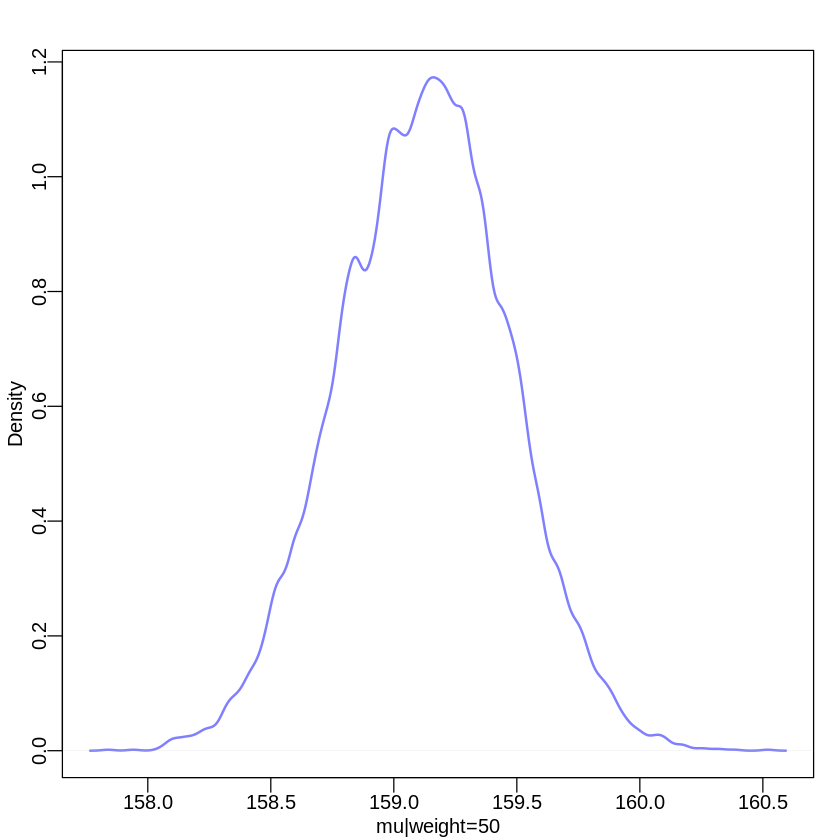

In [116]:
post <- extract.samples( m4.3 )
mu_at_50 <- post$a + post$b * ( 50 - xbar )
dens( mu_at_50 , col=rangi2 , lwd=2 , xlab="mu|weight=50" )

In [117]:
HPDI( mu_at_50 , prob=0.89 )

|0.89    0.89| 
158.5751 159.6669

In [118]:
mu <- link( m4.3 )
str(mu)

 num [1:1000, 1:352] 157 157 158 157 157 ...


In [119]:
precis(mu)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V343,V344,V345,V346,V347,V348,V349,V350,V351,V352
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
156.9428,146.4874,142.2268,161.7522,150.9048,170.9269,148.1079,164.0002,144.9975,163.0853,⋯,153.4402,156.9950,149.1796,150.6957,150.4865,156.2109,144.4224,160.9419,162.6932,161.2817
156.9786,147.1852,143.1944,161.4835,151.3229,170.0772,148.7031,163.5891,145.7896,162.7322,⋯,153.6978,157.0275,149.7070,151.1270,150.9311,156.2930,145.2510,160.7245,162.3649,161.0428
157.7074,146.6876,142.1970,162.7764,151.3434,172.4463,148.3957,165.1457,145.1173,164.1815,⋯,154.0157,157.7625,149.5252,151.1230,150.9027,156.9360,144.5112,161.9224,163.7682,162.2806
157.2560,147.5199,143.5524,161.7346,151.6334,170.2780,149.0290,163.8278,146.1325,162.9759,⋯,153.9944,157.3047,150.0269,151.4387,151.2439,156.5745,145.5970,160.9800,162.6108,161.2965
157.4100,147.6074,143.6129,161.9191,151.7490,170.5209,149.1268,164.0267,146.2106,163.1690,⋯,154.1261,157.4590,150.1316,151.5529,151.3569,156.7238,145.6714,161.1594,162.8014,161.4780
157.2986,147.1330,142.9905,161.9748,151.4280,170.8951,148.7087,164.1604,145.6844,163.2709,⋯,153.8931,157.3494,149.7506,151.2246,151.0213,156.5870,145.1253,161.1869,162.8897,161.5173
157.1841,146.2913,141.8525,162.1948,150.8935,171.7532,147.9797,164.5367,144.7391,163.5836,⋯,153.5350,157.2386,149.0962,150.6756,150.4578,156.4216,144.1400,161.3506,163.1751,161.7046
157.1111,146.5004,142.1766,161.9920,150.9834,171.3029,148.1451,164.2733,144.9884,163.3449,⋯,153.5565,157.1641,149.2327,150.7712,150.5590,156.3683,144.4048,161.1697,162.9470,161.5145
157.4695,146.9802,142.7059,162.2945,151.4119,171.4988,148.6061,164.5497,145.4855,163.6319,⋯,153.9556,157.5219,149.6812,151.2022,150.9924,156.7352,144.9086,161.4816,163.2385,161.8225


In [120]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight.seq <- seq( from=25 , to=70 , by=1 )

# use link to compute mu
# for each sample from posterior
# and for each weight in weight.seq
mu <- link( m4.3 , data=data.frame(weight=weight.seq) )
str(mu)

 num [1:1000, 1:46] 136 135 137 136 138 ...


In [121]:
mu

136.1472,137.0632,137.9792,138.8952,139.8112,140.7272,141.6433,142.5593,143.4753,144.3913,⋯,169.1237,170.0397,170.9557,171.8718,172.7878,173.7038,174.6198,175.5358,176.4518,177.3679
135.2825,136.2537,137.2248,138.1960,139.1671,140.1383,141.1094,142.0806,143.0518,144.0229,⋯,170.2440,171.2151,172.1863,173.1574,174.1286,175.0998,176.0709,177.0421,178.0132,178.9844
137.2280,138.0908,138.9535,139.8163,140.6791,141.5419,142.4046,143.2674,144.1302,144.9929,⋯,168.2878,169.1505,170.0133,170.8761,171.7389,172.6016,173.4644,174.3272,175.1899,176.0527
136.1409,137.0594,137.9778,138.8963,139.8148,140.7333,141.6518,142.5703,143.4887,144.4072,⋯,169.2063,170.1248,171.0433,171.9617,172.8802,173.7987,174.7172,175.6357,176.5542,177.4726
138.1691,138.9929,139.8168,140.6406,141.4645,142.2883,143.1122,143.9360,144.7599,145.5837,⋯,167.8276,168.6515,169.4753,170.2992,171.1230,171.9469,172.7707,173.5946,174.4184,175.2423
135.8289,136.7859,137.7428,138.6998,139.6567,140.6136,141.5706,142.5275,143.4845,144.4414,⋯,170.2789,171.2359,172.1928,173.1497,174.1067,175.0636,176.0206,176.9775,177.9345,178.8914
136.4569,137.3645,138.2721,139.1797,140.0873,140.9949,141.9025,142.8101,143.7177,144.6253,⋯,169.1302,170.0378,170.9454,171.8530,172.7606,173.6682,174.5758,175.4834,176.3910,177.2985
137.4903,138.3471,139.2039,140.0607,140.9174,141.7742,142.6310,143.4878,144.3445,145.2013,⋯,168.3343,169.1911,170.0478,170.9046,171.7614,172.6182,173.4750,174.3317,175.1885,176.0453
135.8283,136.7478,137.6672,138.5867,139.5062,140.4256,141.3451,142.2645,143.1840,144.1035,⋯,168.9290,169.8485,170.7680,171.6874,172.6069,173.5264,174.4458,175.3653,176.2848,177.2042
136.2300,137.1688,138.1077,139.0465,139.9854,140.9242,141.8631,142.8019,143.7408,144.6796,⋯,170.0285,170.9673,171.9062,172.8450,173.7839,174.7227,175.6616,176.6004,177.5393,178.4781
135.6424,136.5985,137.5546,138.5107,139.4667,140.4228,141.3789,142.3350,143.2911,144.2471,⋯,170.0613,171.0174,171.9735,172.9296,173.8857,174.8418,175.7978,176.7539,177.7100,178.6661


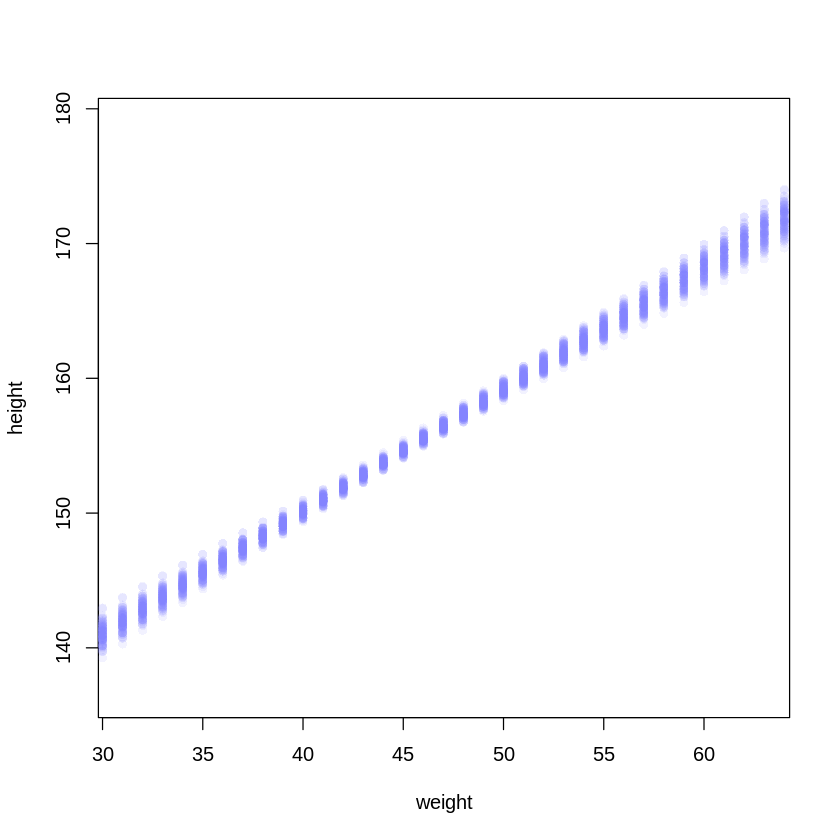

In [122]:
# use type="n" to hide raw data
plot( height ~ weight , d2 , type="n" )

# loop over samples and plot each mu value
for ( i in 1:100 )
points( weight.seq , mu[i,] , pch=16 , col=col.alpha(rangi2,0.1) )

In [123]:
# summarize the distribution of mu
mu.mean <- apply( mu , 2 , mean )
mu.HPDI <- apply( mu , 2 , HPDI , prob=0.89 )

In [124]:
mu.HPDI

|0.89,135.1398,136.1128,137.0969,138.0507,139.0735,140.0412,140.9768,141.9346,142.8788,143.8425,⋯,167.8617,168.7099,169.5593,170.3972,171.2345,172.1119,172.9326,173.7684,174.6057,175.4281
0.89|,137.9371,138.7984,139.6657,140.5008,141.3982,142.2320,143.0364,143.8628,144.6957,145.5504,⋯,170.1350,171.1081,172.0854,173.0464,174.0095,175.0144,175.9554,176.9110,177.8705,178.8371


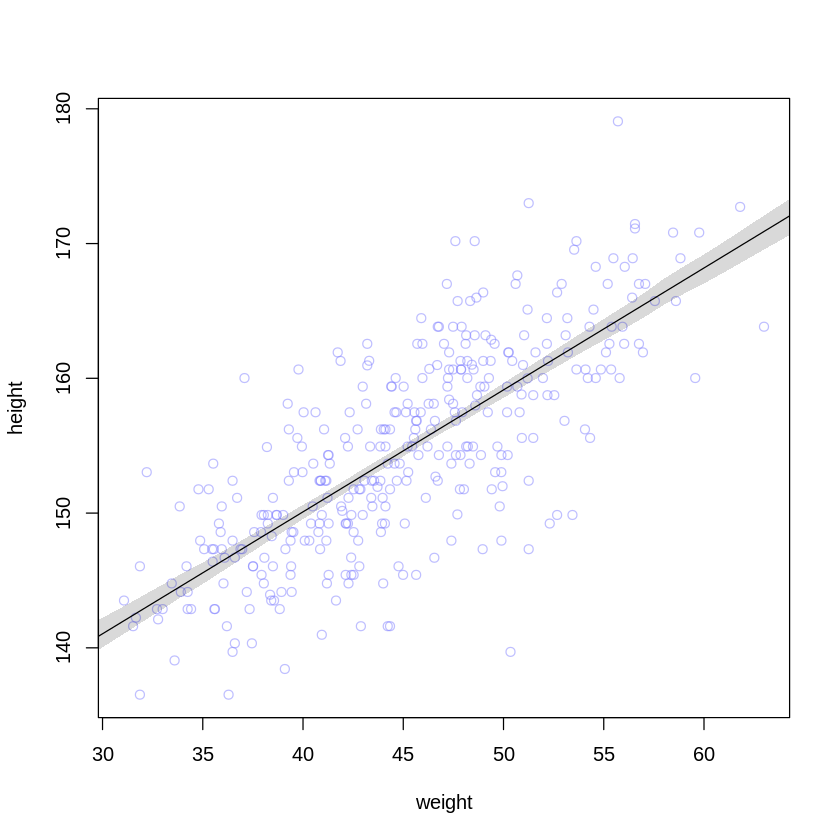

In [125]:
# plot raw data
# fading out points to make line and interval more visible
plot( height ~ weight , data=d2 , col=col.alpha(rangi2,0.5) )

# plot the MAP line, aka the mean mu for each weight
lines( weight.seq , mu.mean )

# plot a shaded region for 89% HPDI
shade( mu.HPDI , weight.seq )

In [126]:
post <- extract.samples(m4.3)
mu.link <- function(weight) post$a + post$b*( weight - xbar )
weight.seq <- seq( from=25 , to=70 , by=1 )
mu <- sapply( weight.seq , mu.link )
mu.mean <- apply( mu , 2 , mean )
mu.HPDI <- apply( mu , 2 , HPDI , prob=0.89 )

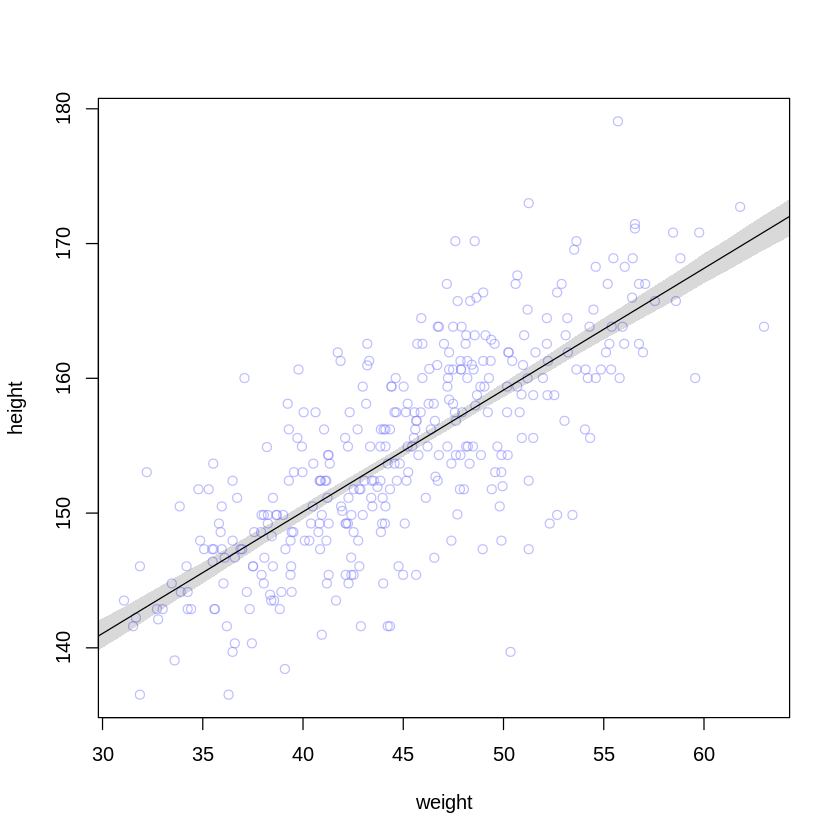

In [127]:
# plot raw data
# fading out points to make line and interval more visible
plot( height ~ weight , data=d2 , col=col.alpha(rangi2,0.5) )

# plot the MAP line, aka the mean mu for each weight
lines( weight.seq , mu.mean )

# plot a shaded region for 89% HPDI
shade( mu.HPDI , weight.seq )

Code 4.59

In [128]:
m4.3


Quadratic approximate posterior distribution

Formula:
height ~ dnorm(mu, sigma)
mu <- a + b * (weight - xbar)
a ~ dnorm(178, 20)
b ~ dlnorm(0, 1)
sigma ~ dunif(0, 50)

Posterior means:
          a           b       sigma 
154.6013671   0.9032807   5.0718809 

Log-likelihood: -1071.01 

In [129]:
sim.height <- sim( m4.3 , data=list(weight=weight.seq), n=1e4 )
str(sim.height)

 num [1:10000, 1:46] 129 129 142 141 138 ...


In [130]:
height.PI <- apply( sim.height , 2 , PI , prob=0.89 )

height.PI

5%,128.5606,129.1720,129.9867,131.0378,131.9964,132.9380,133.6965,134.8705,135.4903,136.3661,⋯,160.7401,161.7810,162.7488,163.6164,164.4566,165.379,166.5007,167.1505,167.8963,168.9543
94%,144.8336,145.6967,146.4888,147.2802,148.3327,149.2575,150.2120,150.9867,151.9545,152.9601,⋯,177.1876,178.3262,179.0706,180.0186,180.9748,181.903,182.5541,183.7016,184.6499,185.5513


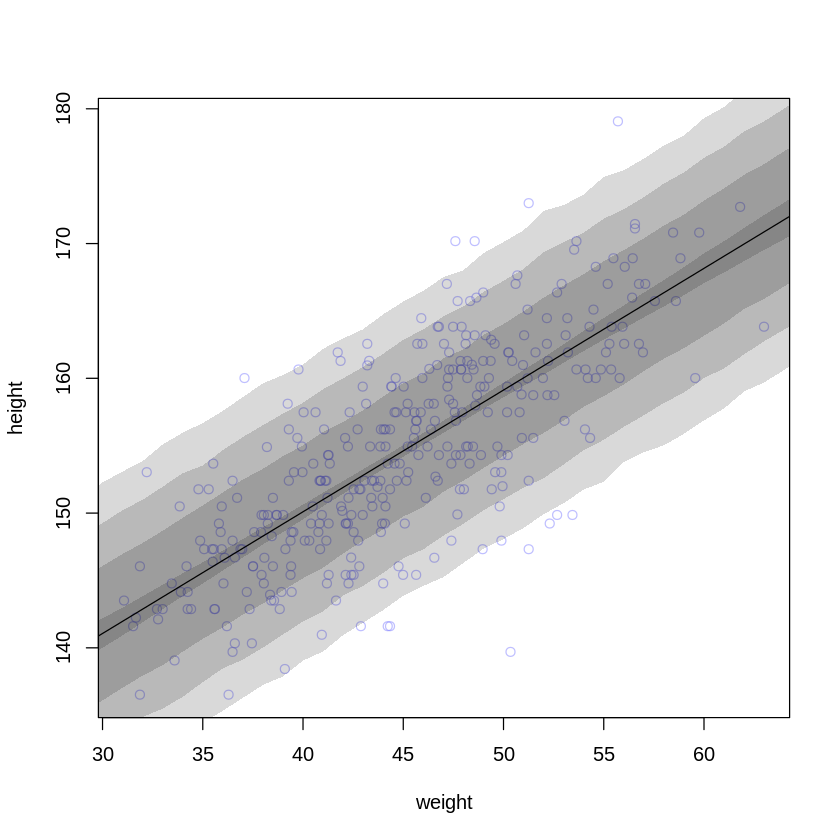

In [131]:
# plot raw data
plot( height ~ weight , d2 , col=col.alpha(rangi2,0.5) )

# draw MAP line
lines( weight.seq , mu.mean )

# draw HPDI region for line
shade( mu.HPDI , weight.seq )

# draw PI region for simulated heights
shade( height.PI , weight.seq )

# draw 67% PI region for simulated heights
shade( apply(sim.height, 2, PI, prob=0.67) , weight.seq )

# draw 97% PI region for simulated heights
shade( apply(sim.height, 2, PI, prob=0.97) , weight.seq )


In [132]:
library(rethinking)
data(Howell1)
d <- Howell1
str(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


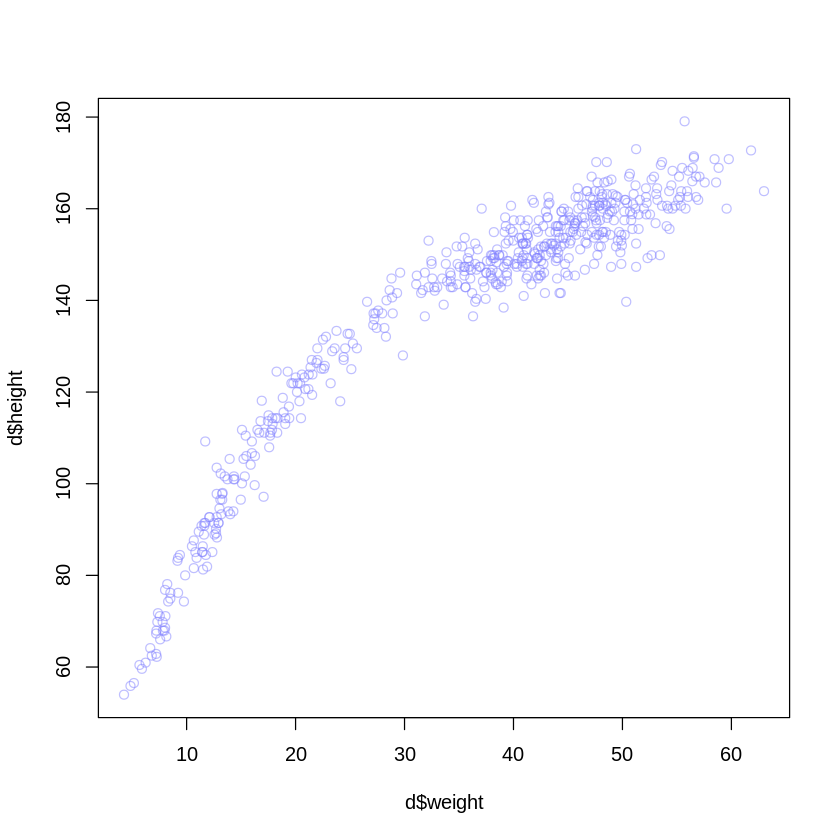

In [133]:
plot(d$height ~ d$weight, d,  col=col.alpha(rangi2,0.5))

In [134]:
d$weight_s <- ( d$weight - mean(d$weight) )/sd(d$weight)
d$weight_s2 <- d$weight_s^2

m4.5 <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + b1*weight_s + b2*weight_s2 ,
        a ~ dnorm( 178 , 20 ) ,
        b1 ~ dlnorm( 0 , 1 ) ,
        b2 ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 50 )
        ) ,
    data=d )

In [135]:
precis( m4.5 )

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,146.059987,0.3689572,145.470322,146.649652
b1,21.730584,0.2888762,21.268904,22.192264
b2,-7.805483,0.2741646,-8.243651,-7.367315
sigma,5.774397,0.1764573,5.492384,6.056410


In [136]:
weight.seq <- seq( from=-2.2 , to=2 , length.out=30 )
pred_dat <- list( weight_s=weight.seq , weight_s2=weight.seq^2 )
mu <- link( m4.5 , data=pred_dat )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI , prob=0.89 )
sim.height <- sim( m4.5 , data=pred_dat )
height.PI <- apply( sim.height , 2 , PI , prob=0.89 )

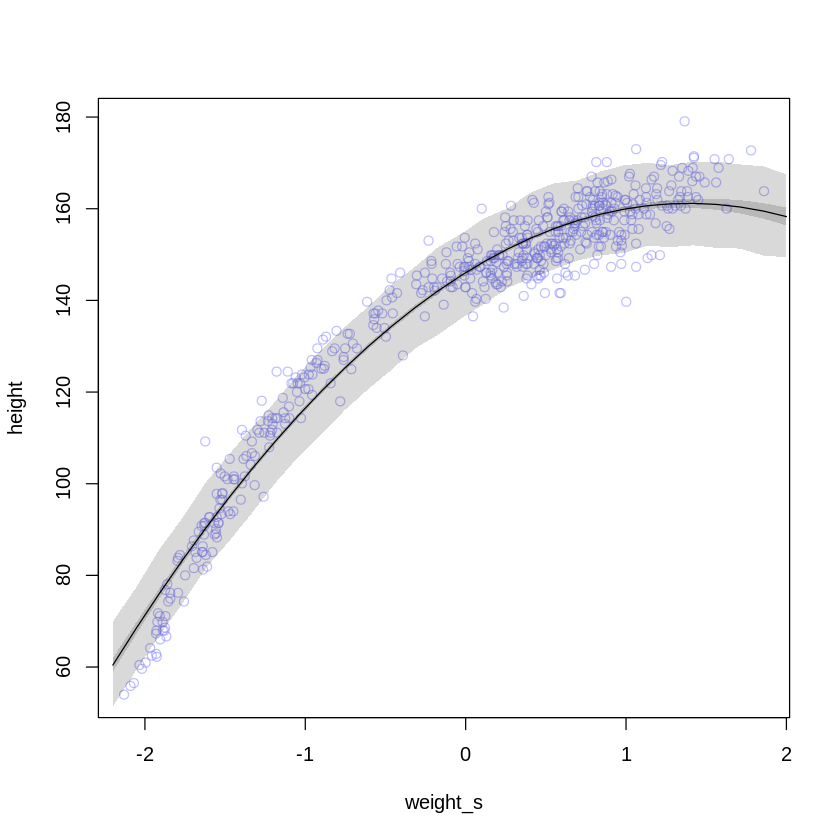

In [137]:
plot( height ~ weight_s , d , col=col.alpha(rangi2,0.5) )
lines( weight.seq , mu.mean )
shade( mu.PI , weight.seq )
shade( height.PI , weight.seq )

In [138]:
d$weight_s3 <- d$weight_s^3
m4.6 <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + b1*weight_s + b2*weight_s2 + b3*weight_s3 ,
        a ~ dnorm( 178 , 20 ) ,
        b1 ~ dlnorm( 0 , 1 ) ,
        b2 ~ dnorm( 0 , 10 ) ,
        b3 ~ dnorm( 0 , 10 ) ,
        sigma ~ dunif( 0 , 50 )
        ) ,
    data=d )

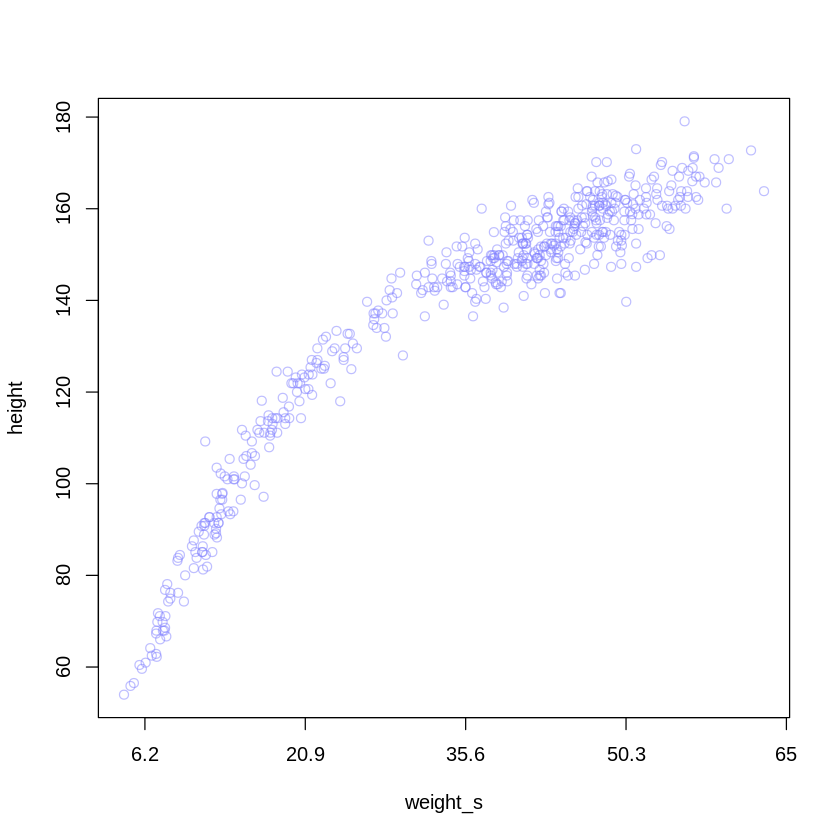

In [139]:
plot( height ~ weight_s , d , col=col.alpha(rangi2,0.5) , xaxt="n" )

at <- c(-2,-1,0,1,2)
labels <- at*sd(d$weight) + mean(d$weight)
axis( side=1 , at=at , labels=round(labels,1) )

Code 4.72 - Splines

In [140]:
library(rethinking)
data(cherry_blossoms)
d <- cherry_blossoms
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
year,1408.000000,350.8845964,867.77000,1948.23000,▇▇▇▇▇▇▇▇▇▇▇▇▁
doy,104.540508,6.4070362,94.43000,115.00000,▁▂▅▇▇▃▁▁
temp,6.141886,0.6636479,5.15000,7.29470,▁▃▅▇▃▂▁▁
temp_upper,7.185151,0.9929206,5.89765,8.90235,▁▂▅▇▇▅▂▂▁▁▁▁▁▁▁
temp_lower,5.098941,0.8503496,3.78765,6.37000,▁▁▁▁▁▁▁▃▅▇▃▂▁▁▁


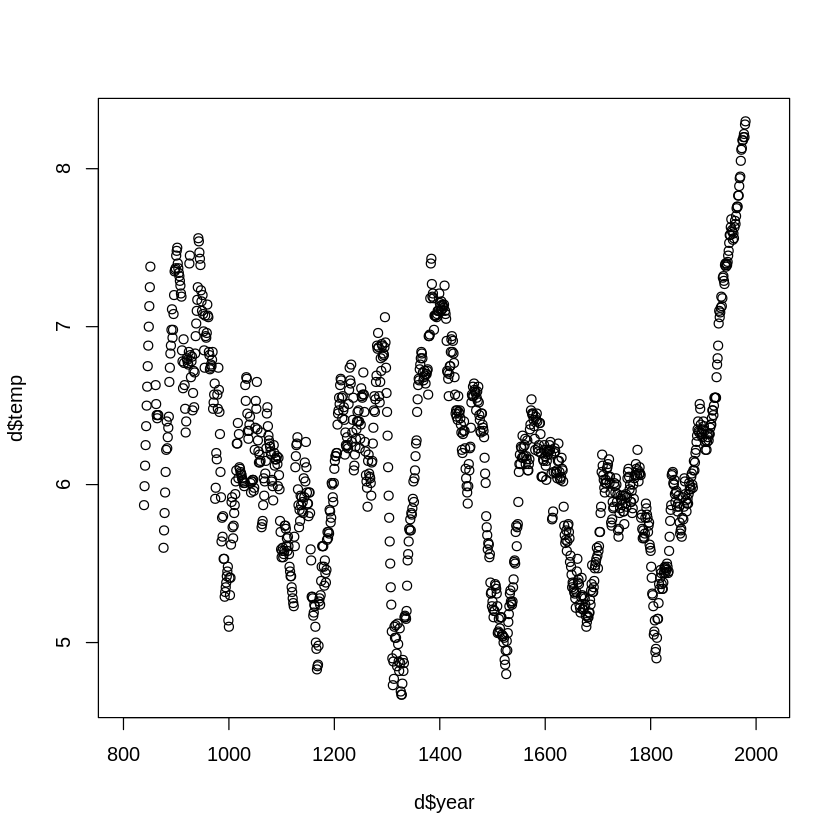

In [141]:
plot(d$temp ~ d$year, d)

In [142]:
d2 <- d[ complete.cases(d$temp) , ] # complete cases on temp
num_knots <- 15
knot_list <- quantile( d2$year , probs=seq(0,1,length.out=num_knots) )
knot_list

0% 7.142857% 14.28571% 21.42857% 28.57143% 35.71429% 42.85714%       50% 
 839.0000  937.2143 1017.4286 1097.6429 1177.8571 1258.0714 1338.2857 1418.5000 
57.14286% 64.28571% 71.42857% 78.57143% 85.71429% 92.85714%      100% 
1498.7143 1578.9286 1659.1429 1739.3571 1819.5714 1899.7857 1980.0000

In [143]:
library(splines)
B <- bs(d2$year,
        knots=knot_list[-c(1,num_knots)] ,
        degree=3 , intercept=TRUE )

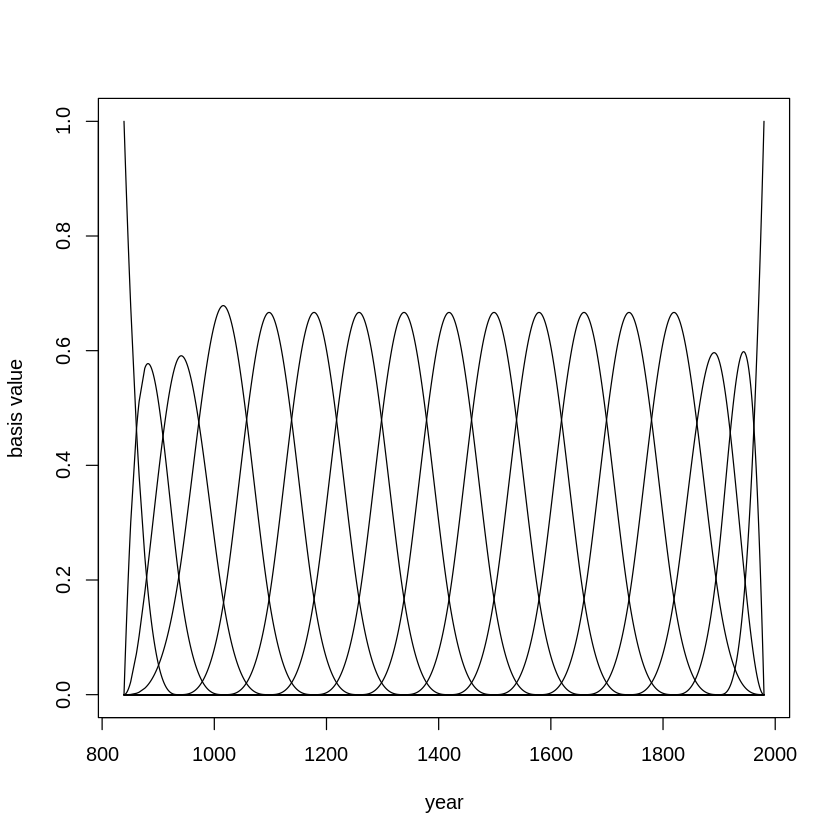

In [144]:
plot( NULL , xlim=range(d2$year) , ylim=c(0,1) , xlab="year" , ylab="basis value" )
for ( i in 1:ncol(B) ) lines( d2$year , B[,i] )

In [145]:
m4.7 <- quap(
    alist(
        T ~ dnorm( mu , sigma ) ,
        mu <- a + B %*% w ,
        a ~ dnorm(6,10),
        w ~ dnorm(0,1),
        sigma ~ dexp(1)
        ),
    data=list( T=d2$temp , B=B ) ,
    start=list( w=rep( 0 , ncol(B) ) ) )

In [146]:
precis(m4.7,depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
w[1],0.09748363,0.267673858,-0.3303109,0.5252782
w[2],0.23887248,0.279070943,-0.2071368,0.6848817
w[3],1.20070050,0.271684865,0.7664956,1.6349054
w[4],-0.82198189,0.259287132,-1.2363728,-0.4075910
w[5],0.10175465,0.257448143,-0.3096972,0.5132065
w[6],-1.40469912,0.257092914,-1.8155833,-0.9938150
w[7],1.15649933,0.256907709,0.7459112,1.5670875
w[8],-1.91586599,0.256912324,-2.3264615,-1.5052705
w[9],2.34740494,0.256876256,1.9368671,2.7579428


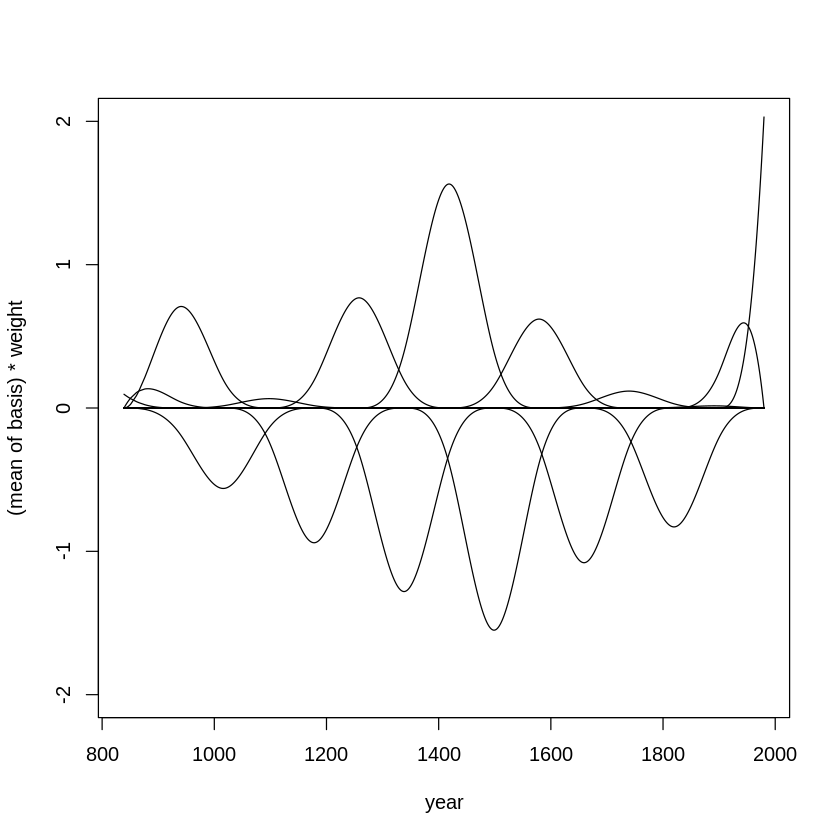

In [147]:
post <- extract.samples(m4.7)
w <- apply( post$w , 2 , mean )
plot( NULL , xlim=range(d2$year) , ylim=c(-2,2) ,
xlab="year" , ylab="(mean of basis) * weight" )
for ( i in 1:ncol(B) ) lines( d2$year , w[i]*B[,i] )

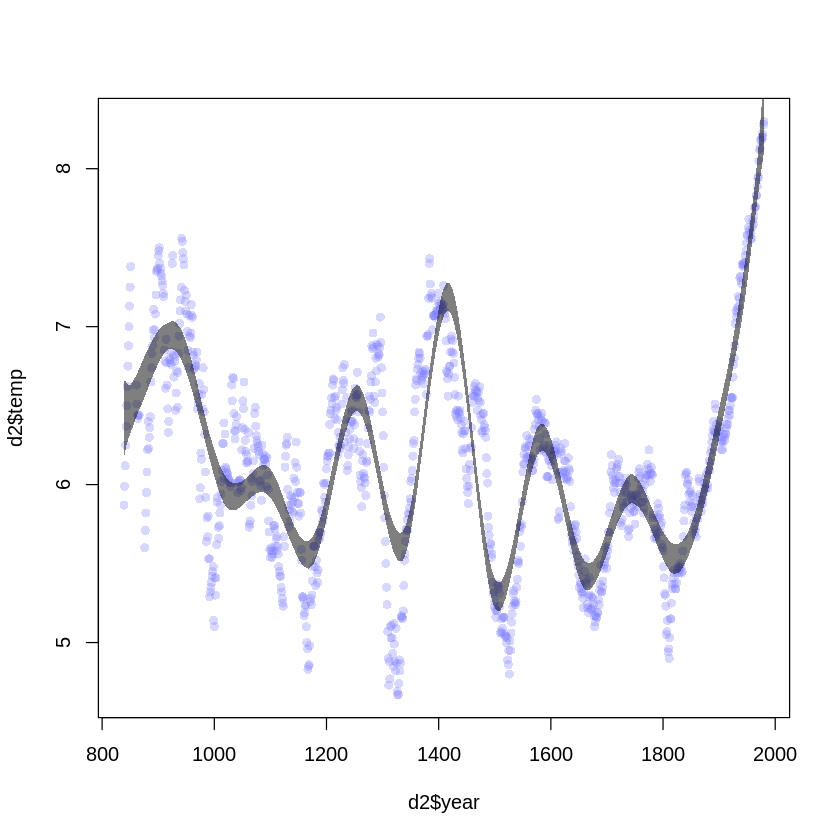

In [148]:
mu <- link( m4.7 )
mu_PI <- apply(mu,2,PI,0.97)
plot( d2$year , d2$temp , col=col.alpha(rangi2,0.3) , pch=16 )
shade( mu_PI , d2$year , col=col.alpha("black",0.5) )